# 🚀 Proactive Churn Prevention Multi-Agent System

### Building an AI-Powered Customer Retention Engine with Google ADK v1.0.0+ & Vertex AI

---

### Business Objective
Transform reactive churn prevention into **proactive customer retention** by predicting churn 45-60 days in advance and deploying personalized interventions.

**Target Metrics:**
- Retention Rate: 70% → 85% (15% lift)
- Intervention Timing: 5-10 days → 45-60 days before churn
- Expected ROI: 8-12x on retention investments

### Technical Architecture
```
┌─────────────────────────────────────────────────────────────────┐
│                    ORCHESTRATOR AGENT                           │
│         (Coordinates workflow, manages agent communication)     │
└─────────────────────┬───────────────────────────────────────────┘
                      │
        ┌─────────────┼─────────────┬─────────────┐
        ▼             ▼             ▼             ▼
┌───────────┐  ┌───────────┐  ┌───────────┐  ┌───────────┐
│ BEHAVIORAL│  │ PREDICTIVE│  │INTERVENTION│ │ EVALUATION│
│   AGENT   │  │   AGENT   │  │   AGENT    │ │   AGENT   │
│ (Parallel)│  │(Sequential)│ │(Sequential)│ │  (Loop)   │
└───────────┘  └───────────┘  └───────────┘  └───────────┘
```

### ADK v1.0.0+ Key Changes
- `Agent` replaces `LlmAgent`
- `BuiltInCodeExecutor` replaces `CodeExecutionTool`
- Pass functions directly to `tools` parameter
- **Each agent can only have ONE parent** - create separate instances for different workflows

### Key Concepts Implemented (6 of 8)
1. ✅ **Multi-Agent System** - Parallel + Sequential + Loop agents
2. ✅ **Tools** - Built-in (Code Execution) + Custom tools
3. ✅ **Sessions & Memory** - InMemorySessionService + long-term customer history
4. ✅ **Context Engineering** - Context compaction for large datasets
5. ✅ **Observability** - Logging, tracing, metrics
6. ✅ **Agent Evaluation** - Distributed evaluation agents

---

## Section 1: Setup & Configuration

Install required packages and configure Google Cloud authentication.

In [4]:
# Verify installations
import importlib

packages = [
    ('google.adk', 'google-adk'),
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('vertexai', 'vertexai'),
    ('pandas', 'pandas'),
    ('numpy', 'numpy'),
    ('sklearn', 'scikit-learn'),
    ('lifelines', 'lifelines')
]

for pkg, name in packages:
    try:
        mod = importlib.import_module(pkg)
        version = getattr(mod, '__version__', 'unknown')
        print(f"✅ {name}: {version}")
    except ImportError as e:
        print(f"❌ {name}: {e}")

✅ google-adk: 1.19.0
✅ google-cloud-aiplatform: 1.128.0
✅ vertexai: 1.128.0
✅ pandas: 2.3.3
✅ numpy: 2.3.5
✅ scikit-learn: 1.7.2
✅ lifelines: 0.30.0


In [5]:
# Google Cloud Authentication for Local Notebook
import os
import google.auth

# Set up Cloud Credentials Locally
# This relies on the 'gcloud auth application-default login' command run previously
try:
    credentials, project = google.auth.default()
    print("✅ Cloud credentials configured")
except Exception as e:
    print(f"❌ Error loading credentials: {e}")
    print("Please run 'gcloud auth application-default login' in your terminal.")

# Google Cloud Configuration
PROJECT_ID = "sunlit-gamma-342416"
REGION = "us-east4"  # Vertex AI Agent Engine region
BUCKET_NAME = f"{PROJECT_ID}-churn-agents"  # GCS bucket for artifacts

# Model Configuration
LLM_MODEL = "gemini-2.5-flash"  # Cost-efficient model
EMBEDDING_MODEL = "text-embedding-004"

# Agent Configuration
AGENT_NAME = "churn_prevention_agent"
AGENT_DISPLAY_NAME = "Proactive Churn Prevention System"

# Set environment variables
# Note: Explicitly setting GOOGLE_CLOUD_PROJECT is good practice locally
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["GOOGLE_CLOUD_REGION"] = REGION

print(f"Project: {PROJECT_ID}")
print(f"Region: {REGION}")
print(f"Model: {LLM_MODEL}")

/Users/ibrahimabarry/Documents/Proactive-churn-prevention/churn_env/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


✅ Cloud credentials configured
Project: sunlit-gamma-342416
Region: us-east4
Model: gemini-2.5-flash


## Section 2: Data Preparation

Generate synthetic customer data with realistic churn patterns for demonstration.

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
from typing import Dict, Any, List, Optional

# Set random seed for reproducibility
n_seed = 42
np.random.seed(n_seed)

def generate_customer_data(n_customers: int = 1000) -> pd.DataFrame:
    """
    Generate synthetic customer churn dataset with behavioral signals.
    """
    # Customer IDs
    customer_ids = [f"CUST_{i:06d}" for i in range(1, n_customers + 1)]
    
    # Demographics
    tenure_months = np.random.exponential(scale=24, size=n_customers).astype(int)
    tenure_months = np.clip(tenure_months, 1, 120)
    
    subscription_tiers = np.random.choice(
        ['Basic', 'Standard', 'Premium', 'Enterprise'],
        size=n_customers,
        p=[0.30, 0.35, 0.25, 0.10]
    )
    
    tier_charges = {'Basic': 29, 'Standard': 79, 'Premium': 149, 'Enterprise': 299}
    monthly_charges = [tier_charges[tier] * np.random.uniform(0.9, 1.1) for tier in subscription_tiers]
    
    # Behavioral signals
    login_frequency = np.random.poisson(lam=15, size=n_customers)
    feature_usage_pct = np.random.beta(a=2, b=5, size=n_customers) * 100
    support_tickets_90d = np.random.poisson(lam=2, size=n_customers)
    
    # Financial indicators
    payment_delays_12m = np.random.poisson(lam=0.5, size=n_customers)
    discount_count = np.random.poisson(lam=1, size=n_customers)
    
    # Engagement metrics
    nps_score = np.random.choice(range(0, 11), size=n_customers, p=[
        0.02, 0.02, 0.03, 0.05, 0.08, 0.10, 0.15, 0.20, 0.18, 0.12, 0.05
    ])
    email_open_rate = np.random.beta(a=3, b=4, size=n_customers)
    last_activity_days = np.random.exponential(scale=7, size=n_customers).astype(int)
    
    # Generate churn labels
    churn_score = (
        -0.02 * tenure_months +
        -0.03 * login_frequency +
        -0.02 * feature_usage_pct +
        0.15 * support_tickets_90d +
        0.25 * payment_delays_12m +
        -0.1 * nps_score +
        0.02 * last_activity_days +
        np.random.normal(0, 0.5, n_customers)
    )
    
    churn_probability = 1 / (1 + np.exp(-churn_score))
    churned = np.random.binomial(1, churn_probability)
    
    days_until_churn = np.where(
        churned == 1,
        np.random.exponential(scale=45, size=n_customers).astype(int),
        np.nan
    )
    
    df = pd.DataFrame({
        'customer_id': customer_ids,
        'tenure_months': tenure_months,
        'subscription_tier': subscription_tiers,
        'monthly_charges': np.round(monthly_charges, 2),
        'login_frequency_monthly': login_frequency,
        'feature_usage_pct': np.round(feature_usage_pct, 1),
        'support_tickets_90d': support_tickets_90d,
        'payment_delays_12m': payment_delays_12m,
        'discount_count': discount_count,
        'nps_score': nps_score,
        'email_open_rate': np.round(email_open_rate, 3),
        'last_activity_days': last_activity_days,
        'churned': churned,
        'days_until_churn': days_until_churn,
        'churn_probability': np.round(churn_probability, 4)
    })
    
    return df

# Generate dataset
customer_df = generate_customer_data(n_customers=3000)

print(f"Dataset Shape: {customer_df.shape}")
print(f"Churn Rate: {customer_df['churned'].mean():.1%}")
print(f"\nSample Records:")
customer_df.head()

Dataset Shape: (3000, 15)
Churn Rate: 19.4%

Sample Records:


,customer_id,tenure_months,subscription_tier,monthly_charges,login_frequency_monthly,feature_usage_pct,support_tickets_90d,payment_delays_12m,discount_count,nps_score,email_open_rate,last_activity_days,churned,days_until_churn,churn_probability
0,CUST_000001,11,Premium,153.42,21,17.3,0,0,1,8,0.396,0,0,NaN,0.1058
1,CUST_000002,72,Premium,139.24,18,20.3,0,0,1,9,0.517,0,0,NaN,0.0272
2,CUST_000003,31,Basic,31.16,16,37.2,1,2,1,1,0.661,2,1,36.0,0.4407
3,CUST_000004,21,Standard,80.79,13,24.5,1,2,1,9,0.553,0,0,NaN,0.1490
4,CUST_000005,4,Standard,73.58,15,15.1,2,0,0,8,0.575,11,1,77.0,0.2099


In [8]:
# Feature Engineering

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # Engagement Score
    df['engagement_score'] = (
        0.3 * (df['login_frequency_monthly'] / df['login_frequency_monthly'].max()) +
        0.3 * (df['feature_usage_pct'] / 100) +
        0.2 * df['email_open_rate'] +
        0.2 * (df['nps_score'] / 10)
    ) * 100
    
    # Risk Indicators
    df['is_high_value'] = (df['subscription_tier'].isin(['Premium', 'Enterprise'])).astype(int)
    df['has_payment_issues'] = (df['payment_delays_12m'] > 0).astype(int)
    df['is_heavy_support_user'] = (df['support_tickets_90d'] >= 3).astype(int)
    df['is_inactive'] = (df['last_activity_days'] > 14).astype(int)
    
    # CLV
    df['clv_estimate'] = df['monthly_charges'] * df['tenure_months'] * 0.8
    
    # Risk Score
    df['risk_score_baseline'] = (
        25 * df['has_payment_issues'] +
        20 * df['is_heavy_support_user'] +
        15 * df['is_inactive'] +
        10 * (df['nps_score'] < 7).astype(int) +
        30 * (1 - df['engagement_score'] / 100)
    )
    df['risk_score_baseline'] = np.clip(df['risk_score_baseline'], 0, 100)
    
    return df

customer_df = engineer_features(customer_df)
print("✅ Feature engineering complete")
print(customer_df[['customer_id', 'engagement_score', 'risk_score_baseline', 'clv_estimate']].head())

✅ Feature engineering complete
   customer_id  engagement_score  risk_score_baseline  clv_estimate
0  CUST_000001             50.11               14.967      1350.096
1  CUST_000002             52.43               14.271      8020.224
2  CUST_000003             42.38               52.286       772.768
3  CUST_000004             49.41               40.177      1357.272
4  CUST_000005             47.03               15.891       235.456


In [9]:
# Train/Test Split
from sklearn.model_selection import train_test_split

feature_cols = [
    'tenure_months', 'monthly_charges', 'login_frequency_monthly',
    'feature_usage_pct', 'support_tickets_90d', 'payment_delays_12m',
    'discount_count', 'nps_score', 'email_open_rate', 'last_activity_days',
    'engagement_score', 'is_high_value', 'has_payment_issues',
    'is_heavy_support_user', 'is_inactive'
]

X = customer_df[feature_cols]
y = customer_df['churned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11, stratify=y
)

print(f"Training Set: {len(X_train)} customers ({y_train.mean():.1%} churn rate)")
print(f"Test Set: {len(X_test)} customers ({y_test.mean():.1%} churn rate)")

Training Set: 2400 customers (19.4% churn rate)
Test Set: 600 customers (19.3% churn rate)


In [10]:
# Save dataset
customer_df.to_csv('/tmp/customer_churn_data.csv', index=False)
print("✅ Dataset saved to /tmp/customer_churn_data.csv")

✅ Dataset saved to /tmp/customer_churn_data.csv


## Section 3: ADK Imports & Tool Definitions

Using ADK v1.0.0+ API with correct imports and patterns.

In [12]:
# ============================================================
# CORE IMPORTS FOR ADK v1.0.0+
# ============================================================

from google.adk.agents import (
    Agent,              # Main agent class (replaces LlmAgent)
    SequentialAgent,    # Runs sub-agents in sequence
    ParallelAgent,      # Runs sub-agents in parallel
    LoopAgent           # Runs sub-agents in a loop
)
from google.adk.code_executors import BuiltInCodeExecutor  
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.genai import types as genai_types
import logging

# For async support in notebooks
import nest_asyncio
nest_asyncio.apply()
import asyncio

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(name)s | %(levelname)s | %(message)s'
)
logger = logging.getLogger('ChurnPreventionAgents')

print("✅ ADK v1.0.0+ imports successful")

✅ ADK v1.0.0+ imports successful


In [13]:
# ============================================================
# CUSTOM TOOL FUNCTIONS
# In ADK v1.0.0+, pass functions directly to agents
# The function name becomes the tool name
# The docstring becomes the description
# ============================================================

def calculate_churn_score(customer_id: str) -> Dict[str, Any]:
    """
    Calculate churn risk score for a specific customer using behavioral signals.
    
    Args:
        customer_id: Unique customer identifier (e.g., CUST_000001)
        
    Returns:
        Dictionary with churn_probability, risk_tier, key_risk_factors, and confidence
    """
    logger.info(f"Calculating churn score for {customer_id}")
    
    df = pd.read_csv('/tmp/customer_churn_data.csv')
    customer = df[df['customer_id'] == customer_id]
    
    if customer.empty:
        return {"error": f"Customer {customer_id} not found"}
    
    c = customer.iloc[0]
    
    # Calculate churn probability
    base_risk = c['risk_score_baseline'] / 100
    engagement_factor = 1 - (c['engagement_score'] / 100)
    churn_prob = np.clip(
        0.3 * base_risk + 0.4 * engagement_factor + 0.3 * c['churn_probability'],
        0, 1
    )
    
    # Determine risk tier
    if churn_prob >= 0.75:
        risk_tier = "Critical"
    elif churn_prob >= 0.50:
        risk_tier = "High"
    elif churn_prob >= 0.25:
        risk_tier = "Medium"
    else:
        risk_tier = "Low"
    
    # Identify risk factors
    risk_factors = []
    if c['has_payment_issues']:
        risk_factors.append("Payment issues detected")
    if c['is_heavy_support_user']:
        risk_factors.append("High support ticket volume")
    if c['is_inactive']:
        risk_factors.append("Product inactivity")
    if c['nps_score'] < 7:
        risk_factors.append("Low satisfaction score")
    if c['engagement_score'] < 30:
        risk_factors.append("Low engagement")
    
    days_estimate = int(60 * (1 - churn_prob)) if churn_prob > 0.3 else None
    
    return {
        "customer_id": customer_id,
        "churn_probability": round(float(churn_prob), 4),
        "risk_tier": risk_tier,
        "days_until_churn": days_estimate,
        "confidence": 0.85,
        "key_risk_factors": risk_factors if risk_factors else ["No major risk factors"]
    }

In [14]:
def recommend_intervention(customer_id: str, churn_probability: float, risk_factors: List[str]) -> Dict[str, Any]:
    """
    Generate personalized retention intervention based on churn prediction.
    
    Args:
        customer_id: Customer identifier
        churn_probability: Predicted churn probability (0-1)
        risk_factors: List of identified risk factors
        
    Returns:
        Dictionary with intervention_type, priority, expected_lift, roi_estimate
    """
    logger.info(f"Generating intervention for {customer_id}")
    
    df = pd.read_csv('/tmp/customer_churn_data.csv')
    customer = df[df['customer_id'] == customer_id]
    
    if customer.empty:
        return {"error": f"Customer {customer_id} not found"}
    
    c = customer.iloc[0]
    clv = c['clv_estimate']
    tier = c['subscription_tier']
    
    interventions = {
        "Payment issues detected": {"type": "Payment flexibility program", "base_lift": 0.25, "cost_pct": 0.05},
        "High support ticket volume": {"type": "Dedicated success manager", "base_lift": 0.30, "cost_pct": 0.15},
        "Product inactivity": {"type": "Re-engagement campaign with training", "base_lift": 0.35, "cost_pct": 0.08},
        "Low satisfaction score": {"type": "Executive outreach + service credit", "base_lift": 0.28, "cost_pct": 0.12},
        "Low engagement": {"type": "Personalized feature adoption program", "base_lift": 0.32, "cost_pct": 0.06}
    }
    
    if risk_factors and risk_factors[0] != "No major risk factors":
        intervention = interventions.get(risk_factors[0], {
            "type": "Standard retention outreach", "base_lift": 0.15, "cost_pct": 0.03
        })
    else:
        intervention = {"type": "Proactive check-in", "base_lift": 0.10, "cost_pct": 0.02}
    
    tier_multiplier = {'Basic': 0.8, 'Standard': 1.0, 'Premium': 1.2, 'Enterprise': 1.4}.get(tier, 1.0)
    expected_lift = intervention['base_lift'] * tier_multiplier
    estimated_cost = intervention['cost_pct'] * clv
    value_at_risk = clv * churn_probability
    value_saved = value_at_risk * expected_lift
    roi = value_saved / max(estimated_cost, 1)
    
    if churn_probability >= 0.75 and clv > 5000:
        priority = 1
    elif churn_probability >= 0.50 or clv > 3000:
        priority = 2
    elif churn_probability >= 0.25:
        priority = 3
    else:
        priority = 4
    
    return {
        "customer_id": customer_id,
        "intervention_type": intervention['type'],
        "priority": priority,
        "expected_lift": round(expected_lift, 4),
        "estimated_cost": round(float(estimated_cost), 2),
        "roi_estimate": round(float(roi), 2),
        "personalization_notes": f"{tier} tier, {c['tenure_months']} months tenure, CLV at risk: ${value_at_risk:,.0f}"
    }

In [15]:
def get_customer_behavior(customer_id: str) -> Dict[str, Any]:
    """
    Retrieve comprehensive behavioral summary for a customer.
    
    Args:
        customer_id: Unique customer identifier
        
    Returns:
        Dictionary with profile, engagement, health_indicators, and risk_flags
    """
    logger.info(f"Fetching behavior data for {customer_id}")
    
    df = pd.read_csv('/tmp/customer_churn_data.csv')
    customer = df[df['customer_id'] == customer_id]
    
    if customer.empty:
        return {"error": f"Customer {customer_id} not found"}
    
    c = customer.iloc[0]
    
    return {
        "customer_id": customer_id,
        "profile": {
            "tenure_months": int(c['tenure_months']),
            "subscription_tier": c['subscription_tier'],
            "monthly_charges": float(c['monthly_charges']),
            "clv_estimate": float(c['clv_estimate'])
        },
        "engagement": {
            "login_frequency_monthly": int(c['login_frequency_monthly']),
            "feature_usage_pct": float(c['feature_usage_pct']),
            "email_open_rate": float(c['email_open_rate']),
            "last_activity_days": int(c['last_activity_days']),
            "engagement_score": round(float(c['engagement_score']), 2)
        },
        "health_indicators": {
            "nps_score": int(c['nps_score']),
            "support_tickets_90d": int(c['support_tickets_90d']),
            "payment_delays_12m": int(c['payment_delays_12m'])
        },
        "risk_flags": {
            "is_high_value": bool(c['is_high_value']),
            "has_payment_issues": bool(c['has_payment_issues']),
            "is_heavy_support_user": bool(c['is_heavy_support_user']),
            "is_inactive": bool(c['is_inactive'])
        }
    }

In [16]:
def run_survival_analysis(risk_tier: str = "all") -> Dict[str, Any]:
    """
    Perform Kaplan-Meier survival analysis on customer data.
    
    Args:
        risk_tier: Filter by risk tier (Low/Medium/High/Critical/all)
        
    Returns:
        Dictionary with survival statistics and interpretation
    """
    from lifelines import KaplanMeierFitter
    
    logger.info(f"Running survival analysis for risk tier: {risk_tier}")
    
    df = pd.read_csv('/tmp/customer_churn_data.csv')
    T = df['tenure_months']
    E = df['churned']
    
    kmf = KaplanMeierFitter()
    kmf.fit(T, E, label='Overall')
    
    median_survival = kmf.median_survival_time_
    
    return {
        "analysis_type": "Kaplan-Meier Survival Analysis",
        "sample_size": len(df),
        "event_rate": float(E.mean()),
        "median_survival_months": float(median_survival) if not np.isinf(median_survival) else None,
        "interpretation": f"Based on {len(df)} customers with {E.mean():.1%} churn rate."
    }


In [17]:
def list_at_risk_customers(min_probability: float = 0.5, limit: int = 10) -> Dict[str, Any]:
    """
    Get prioritized list of customers above a churn probability threshold.
    
    Args:
        min_probability: Minimum churn probability threshold (0-1)
        limit: Maximum number of customers to return
        
    Returns:
        Dictionary with threshold, count, total_clv_at_risk, and customer list
    """
    logger.info(f"Listing at-risk customers (prob >= {min_probability})")
    
    df = pd.read_csv('/tmp/customer_churn_data.csv')
    at_risk = df[df['churn_probability'] >= min_probability].nlargest(limit, 'churn_probability')
    
    customers = []
    for _, row in at_risk.iterrows():
        customers.append({
            "customer_id": row['customer_id'],
            "churn_probability": float(row['churn_probability']),
            "subscription_tier": row['subscription_tier'],
            "clv_estimate": float(row['clv_estimate'])
        })
    
    return {
        "threshold": min_probability,
        "count": len(customers),
        "total_clv_at_risk": float(at_risk['clv_estimate'].sum()),
        "customers": customers
    }


print("✅ Custom tool functions defined")

✅ Custom tool functions defined


In [18]:
# Test the tools
print("=" * 50)
print("Testing Tools")
print("=" * 50)

test_id = "CUST_000001"

print(f"\n1. Churn Score for {test_id}:")
score = calculate_churn_score(test_id)
print(json.dumps(score, indent=2))

print(f"\n2. Intervention Recommendation:")
intervention = recommend_intervention(test_id, score['churn_probability'], score['key_risk_factors'])
print(json.dumps(intervention, indent=2))

print(f"\n3. At-Risk Customers:")
at_risk = list_at_risk_customers(min_probability=0.6, limit=3)
print(json.dumps(at_risk, indent=2))

2025-12-12 14:04:30,759 | ChurnPreventionAgents | INFO | Calculating churn score for CUST_000001
2025-12-12 14:04:30,764 | ChurnPreventionAgents | INFO | Generating intervention for CUST_000001
2025-12-12 14:04:30,768 | ChurnPreventionAgents | INFO | Listing at-risk customers (prob >= 0.6)


Testing Tools

1. Churn Score for CUST_000001:
{
  "customer_id": "CUST_000001",
  "churn_probability": 0.2762,
  "risk_tier": "Medium",
  "days_until_churn": null,
  "confidence": 0.85,
  "key_risk_factors": [
    "No major risk factors"
  ]
}

2. Intervention Recommendation:
{
  "customer_id": "CUST_000001",
  "intervention_type": "Proactive check-in",
  "priority": 3,
  "expected_lift": 0.12,
  "estimated_cost": 27.0,
  "roi_estimate": 1.66,
  "personalization_notes": "Premium tier, 11 months tenure, CLV at risk: $373"
}

3. At-Risk Customers:
{
  "threshold": 0.6,
  "count": 3,
  "total_clv_at_risk": 3065.768,
  "customers": [
    {
      "customer_id": "CUST_001593",
      "churn_probability": 0.7949,
      "subscription_tier": "Standard",
      "clv_estimate": 198.12
    },
    {
      "customer_id": "CUST_002306",
      "churn_probability": 0.793,
      "subscription_tier": "Standard",
      "clv_estimate": 713.0880000000001
    },
    {
      "customer_id": "CUST_002407",
     

## Section 4: Agent Definitions

**IMPORTANT:** In ADK v1.0.0+, each agent can only have ONE parent agent. We create separate instances for different workflow patterns.

In [20]:
import logging

# Set the logging level to WARNING (or ERROR) to suppress INFO messages
logging.getLogger('kaleido').setLevel(logging.WARNING)
logging.getLogger('choreographer').setLevel(logging.WARNING)

In [21]:
# Find dataframe variables in memory
import pandas as pd
dataframes = [(name, obj) for name, obj in globals().items() 
              if isinstance(obj, pd.DataFrame) and not name.startswith('_')]

print("Available DataFrames:")
for name, obj in dataframes:
    print(f"  {name}: {obj.shape[0]} rows, {obj.shape[1]} columns")

Available DataFrames:
  customer_df: 3000 rows, 22 columns
  X: 3000 rows, 15 columns
  X_train: 2400 rows, 15 columns
  X_test: 600 rows, 15 columns


In [22]:
# ============================================================
# 4.1 FEATURE IMPORTANCE & SELECTION
# ============================================================

# ----------------------------------------------------------
# STEP 1: Compute Feature Importance for ALL Features
# ----------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

# Safety check: ensure df exists
if 'df' not in dir():
    if 'customer_df' in dir():
        df = customer_df
    elif 'customers_df' in dir():
        df = customers_df
    else:
        raise NameError("❌ No dataframe found. Please run Section 2 first.")

print(f"✅ Using dataframe with {len(df)} rows")

CANDIDATE_FEATURES = [
    'tenure_months', 'monthly_charges', 'login_frequency_monthly',
    'feature_usage_pct', 'support_tickets_90d', 'payment_delays_12m',
    'discount_count', 'nps_score', 'email_open_rate', 'last_activity_days',
    'engagement_score', 'is_high_value', 'has_payment_issues',
    'is_heavy_support_user', 'is_inactive'
]

# Filter to features that exist in df
available_features = [f for f in CANDIDATE_FEATURES if f in df.columns]
print(f"📋 Available features: {len(available_features)}/{len(CANDIDATE_FEATURES)}")

X = df[available_features].copy()
y = df['churned']

# Standardize features (required for comparing coefficient magnitudes)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_scaled, y)

# Extract coefficients
coefficients = dict(zip(available_features, log_reg.coef_[0]))

# Sort by absolute value (importance)
coefficients_sorted = dict(sorted(coefficients.items(), 
                                  key=lambda x: abs(x[1]), reverse=True))

print("\n📊 ALL Feature Coefficients (Logistic Regression):")
print("-" * 55)
print(f"{'Feature':<30} {'Coefficient':<12} {'Direction':<15}")
print("-" * 55)
for feat, coef in coefficients_sorted.items():
    direction = "↑ increases churn" if coef > 0 else "↓ decreases churn"
    print(f"{feat:<30} {coef:>+10.4f}   {direction}")

# ----------------------------------------------------------
# STEP 2: VISUALIZE ALL FEATURES (Before Actionability Filter)
# ----------------------------------------------------------
print("\n" + "=" * 60)
print("📊 VISUALIZING ALL FEATURE IMPORTANCES")
print("=" * 60)

# Display names for visualization (full names for all features chart)
ALL_FEATURE_DISPLAY_NAMES = {
    'tenure_months': 'Tenure',
    'monthly_charges': 'Monthly Charges',
    'login_frequency_monthly': 'Login Frequency',
    'feature_usage_pct': 'Feature Usage',
    'support_tickets_90d': 'Support Tickets',
    'payment_delays_12m': 'Payment Delays',
    'discount_count': 'Discounts Used',
    'nps_score': 'NPS Score',
    'email_open_rate': 'Email Open Rate',
    'last_activity_days': 'Days Inactive',
    'engagement_score': 'Engagement',
    'is_high_value': 'High Value',
    'has_payment_issues': 'Payment Issues',
    'is_heavy_support_user': 'Heavy Support',
    'is_inactive': 'Inactive'
}

# Shortened display names for final selected features chart
FEATURE_DISPLAY_NAMES = {
    'tenure_months': 'Tenure',
    'monthly_charges': 'Monthly Charges',
    'login_frequency_monthly': 'Login Frequency',
    'feature_usage_pct': 'Feature Usage',
    'support_tickets_90d': 'Support Tickets',
    'payment_delays_12m': 'Payment Delays',
    'discount_count': 'Discounts Used',
    'nps_score': 'NPS Score',
    'email_open_rate': 'Email Open Rate',
    'last_activity_days': 'Days Inactive',
    'engagement_score': 'Engagement',
    'is_high_value': 'High Value',
    'has_payment_issues': 'Payment Issues',
    'is_heavy_support_user': 'Heavy Support',
    'is_inactive': 'Inactive'
}


# Prepare data for visualization
features_display = [ALL_FEATURE_DISPLAY_NAMES.get(f, f) for f in coefficients_sorted.keys()]
coef_values = list(coefficients_sorted.values())

# Color: positive (increases churn) = red, negative (decreases churn) = green
colors_all = ['#EF4444' if c > 0 else '#10B981' for c in coef_values]

fig_all = go.Figure(go.Bar(
    x=coef_values,
    y=features_display,
    orientation='h',
    marker_color=colors_all,
    text=[f'{c:+.4f}' for c in coef_values],
    textposition='outside'
))

fig_all.update_layout(
    title='All Features: Logistic Regression Coefficients',
    xaxis_title='Coefficient (+ increases churn risk, - decreases)',
    yaxis_title='',
    template='plotly_white',
    height=450,
    width=850,
    margin=dict(l=130, r=80, t=80, b=50),  # Increased top margin for legend
    xaxis=dict(range=[min(coef_values) - 0.4, max(coef_values) + 0.4])
)

# Legend at top-left (outside chart area)
fig_all.add_annotation(
    x=0.01, y=1.12, xref='paper', yref='paper',
    text='🔴 Increases Churn    🟢 Decreases Churn',
    showarrow=False, 
    font=dict(size=11),
    align='left'
)

fig_all.show()
fig_all.write_image('viz/all_feature_importance.png', scale=2)
print("✅ Saved: viz/all_feature_importance.png")

# ----------------------------------------------------------
# STEP 3: Define Actionability (Based on Visualization Above)
# ----------------------------------------------------------
print("\n" + "=" * 60)
print("🎯 ACTIONABILITY ASSESSMENT")
print("=" * 60)
print("""
Based on the feature importance above, define actionability:
  - High (3): We can directly act on this feature
  - Medium (2): We can partially influence this feature  
  - Low (1): Hard to change or lagging indicator
""")

FEATURE_ACTIONABILITY = {
    # High (3) - Can directly act on
    'has_payment_issues': 3,        # High - send payment reminder, easy fix
    'engagement_score': 3,          # High - trigger re-engagement campaign
    'feature_usage_pct': 3,         # High - offer training/onboarding
    'email_open_rate': 3,           # High - improve email content/timing
    'login_frequency_monthly': 3,   # High - feature announcements, nudges
    
    # Medium (2) - Can partially influence
    'support_tickets_90d': 2,       # Medium - improve support response
    'last_activity_days': 2,        # Medium - send nudge email
    'is_inactive': 2,               # Medium - re-activation campaign
    'discount_count': 2,            # Medium - offer strategic discounts
    'payment_delays_12m': 2,        # Medium - payment plan options
    
    # Low (1) - Hard to change
    'nps_score': 1,                 # Low - lagging indicator, hard to change quickly
    'tenure_months': 1,             # Low - can't change customer history
    'monthly_charges': 1,           # Low - pricing is fixed
    'is_high_value': 1,             # Low - derived from other factors
    'is_heavy_support_user': 1      # Low - derived metric
}

ACTIONABILITY_LABELS = {3: 'High', 2: 'Medium', 1: 'Low'}
ACTIONABILITY_COLORS = {3: '#10B981', 2: '#F59E0B', 1: '#EF4444'}

print("Actionability Scores:")
print("-" * 50)
for feat, score in sorted(FEATURE_ACTIONABILITY.items(), key=lambda x: x[1], reverse=True):
    if feat in available_features:
        coef = coefficients[feat]
        label = ACTIONABILITY_LABELS[score]
        print(f"  {feat:<28} {label:<8} (coef: {coef:+.4f})")

# ----------------------------------------------------------
# STEP 4: Combine Importance × Actionability
# ----------------------------------------------------------
print("\n" + "=" * 60)
print("⚖️ COMBINING IMPORTANCE × ACTIONABILITY")
print("=" * 60)

feature_scores = {}
for feat in available_features:
    coef = coefficients[feat]
    importance = abs(coef)
    actionability = FEATURE_ACTIONABILITY.get(feat, 1)
    combined_score = importance * actionability
    feature_scores[feat] = {
        'coefficient': coef,
        'importance': importance,
        'actionability': actionability,
        'actionability_label': ACTIONABILITY_LABELS[actionability],
        'combined_score': combined_score
    }

feature_scores_sorted = dict(sorted(feature_scores.items(), 
                                    key=lambda x: x[1]['combined_score'], 
                                    reverse=True))

print(f"\n{'Feature':<28} {'|Coef|':<10} {'Action':<8} {'Score':<10}")
print("-" * 60)
for feat, scores in feature_scores_sorted.items():
    print(f"{feat:<28} {scores['importance']:<10.4f} {scores['actionability_label']:<8} {scores['combined_score']:<10.4f}")

# ----------------------------------------------------------
# STEP 5: Select Top Features & Create Final Weights
# ----------------------------------------------------------
print("\n" + "=" * 60)
print("✅ FINAL FEATURE SELECTION")
print("=" * 60)

TOP_N_FEATURES = 10
SELECTED_FEATURES = list(feature_scores_sorted.keys())[:TOP_N_FEATURES]

print(f"\nTop {TOP_N_FEATURES} Features Selected:")
print("-" * 70)
print(f"{'Rank':<6} {'Feature':<28} {'Coef':<12} {'Action':<10} {'Score':<10}")
print("-" * 70)
for i, feat in enumerate(SELECTED_FEATURES, 1):
    scores = feature_scores[feat]
    print(f"{i:<6} {feat:<28} {scores['coefficient']:>+10.4f} {scores['actionability_label']:<10} {scores['combined_score']:<10.4f}")

# Final weights for Predictive Agent
FEATURE_WEIGHTS = {feat: round(coefficients[feat], 4) for feat in SELECTED_FEATURES}

# Shortened display names for final chart
FEATURE_DISPLAY_NAMES = {
    'tenure_months': 'Tenure',
    'monthly_charges': 'Charges',
    'login_frequency_monthly': 'Logins',
    'feature_usage_pct': 'Usage',
    'support_tickets_90d': 'Support',
    'payment_delays_12m': 'Pay Delays',
    'discount_count': 'Discounts',
    'nps_score': 'NPS',
    'email_open_rate': 'Email Open',
    'last_activity_days': 'Inactivity',
    'engagement_score': 'Engagement',
    'is_high_value': 'High Value',
    'has_payment_issues': 'Payment',
    'is_heavy_support_user': 'Heavy Support',
    'is_inactive': 'Inactive'
}


print("\n📊 Final FEATURE_WEIGHTS (for Predictive Agent):")
print("-" * 50)
for feat, weight in FEATURE_WEIGHTS.items():
    direction = "↑ churn" if weight > 0 else "↓ churn"
    print(f"  {feat:<28} {weight:>+.4f}  {direction}")

# ----------------------------------------------------------
# STEP 6: Visualize Selected Features (Colored by Actionability)
# ----------------------------------------------------------
print("\n" + "=" * 60)
print("📊 VISUALIZING SELECTED FEATURES")
print("=" * 60)

features_final = [FEATURE_DISPLAY_NAMES.get(f, f) for f in SELECTED_FEATURES]
weights_final = [FEATURE_WEIGHTS[f] for f in SELECTED_FEATURES]
action_final = [feature_scores[f]['actionability_label'] for f in SELECTED_FEATURES]

# Sort by absolute weight for display
sorted_data = sorted(zip(features_final, weights_final, action_final), 
                     key=lambda x: abs(x[1]), reverse=True)
features_sorted = [d[0] for d in sorted_data]
weights_sorted = [d[1] for d in sorted_data]
action_sorted = [d[2] for d in sorted_data]

# Color by actionability
colors_final = [ACTIONABILITY_COLORS[ACTIONABILITY_LABELS.values().__iter__().__next__() == a and 3 or 
                                     (2 if a == 'Medium' else (1 if a == 'Low' else 3))] 
                for a in action_sorted]
# Simplified color mapping
colors_final = []
for a in action_sorted:
    if a == 'High':
        colors_final.append('#10B981')  # Green
    elif a == 'Medium':
        colors_final.append('#F59E0B')  # Yellow/Orange
    else:
        colors_final.append('#EF4444')  # Red


fig_selected = go.Figure(go.Bar(
    x=weights_sorted,
    y=features_sorted,
    orientation='h',
    marker_color=colors_final,
    text=[f'{w:+.4f}' for w in weights_sorted],
    textposition='outside'
))

fig_selected.update_layout(
    title=f'Selected Features: Top {TOP_N_FEATURES} by Importance × Actionability',
    xaxis_title='Coefficient (+ increases churn, - decreases)',
    yaxis_title='',
    template='plotly_white',
    height=400,
    width=800,
    margin=dict(l=100, r=80, t=80, b=50),  # Increased top margin for legend
    xaxis=dict(range=[min(weights_sorted) - 0.4, max(weights_sorted) + 0.4])
)

# Legend at top-left (outside chart area)
fig_selected.add_annotation(
    x=0.01, y=1.15, xref='paper', yref='paper',
    text='🟢 High    🟡 Medium    🔴 Low Actionability',
    showarrow=False, 
    font=dict(size=11),
    align='left'
)

fig_selected.show()
fig_selected.write_image('viz/feature_weights.png', scale=2)
print("✅ Saved: viz/feature_weights.png")

print("\n" + "=" * 60)
print(f"✅ FEATURE SELECTION COMPLETE: {len(FEATURE_WEIGHTS)} features ready for Predictive Agent")
print("=" * 60)


✅ Using dataframe with 3000 rows
📋 Available features: 15/15

📊 ALL Feature Coefficients (Logistic Regression):
-------------------------------------------------------
Feature                        Coefficient  Direction      
-------------------------------------------------------
tenure_months                     -0.5058   ↓ decreases churn
support_tickets_90d               +0.2714   ↑ increases churn
feature_usage_pct                 -0.1764   ↓ decreases churn
engagement_score                  -0.1705   ↓ decreases churn
nps_score                         -0.1421   ↓ decreases churn
is_inactive                       +0.1269   ↑ increases churn
has_payment_issues                +0.0783   ↑ increases churn
email_open_rate                   +0.0715   ↑ increases churn
is_heavy_support_user             -0.0587   ↓ decreases churn
login_frequency_monthly           -0.0568   ↓ decreases churn
monthly_charges                   +0.0464   ↑ increases churn
is_high_value                     

✅ Saved: viz/all_feature_importance.png

🎯 ACTIONABILITY ASSESSMENT

Based on the feature importance above, define actionability:
  - High (3): We can directly act on this feature
  - Medium (2): We can partially influence this feature  
  - Low (1): Hard to change or lagging indicator

Actionability Scores:
--------------------------------------------------
  has_payment_issues           High     (coef: +0.0783)
  engagement_score             High     (coef: -0.1705)
  feature_usage_pct            High     (coef: -0.1764)
  email_open_rate              High     (coef: +0.0715)
  login_frequency_monthly      High     (coef: -0.0568)
  support_tickets_90d          Medium   (coef: +0.2714)
  last_activity_days           Medium   (coef: +0.0135)
  is_inactive                  Medium   (coef: +0.1269)
  discount_count               Medium   (coef: +0.0231)
  payment_delays_12m           Medium   (coef: +0.0239)
  nps_score                    Low      (coef: -0.1421)
  tenure_months        

✅ Saved: viz/feature_weights.png

✅ FEATURE SELECTION COMPLETE: 10 features ready for Predictive Agent


In [23]:
# ============================================================
# MAIN ORCHESTRATOR AGENT
# This is the primary agent with all tools
# ============================================================

# Initialize code executor
code_executor = BuiltInCodeExecutor()

# Create sub-agents for the orchestrator
behavioral_agent = Agent(
    name="BehavioralMonitoringAgent",
    model=LLM_MODEL,
    description="Real-time customer behavior analysis agent",
    instruction="""You are a Behavioral Monitoring Agent. Analyze customer behavior patterns.
    Use get_customer_behavior to fetch data and identify early warning signals.""",
    tools=[get_customer_behavior],
    code_executor=code_executor
)

predictive_agent = Agent(
    name="PredictiveAnalyticsAgent",
    model=LLM_MODEL,
    description="Churn probability forecasting agent",
    instruction="""You are a Predictive Analytics Agent. Calculate churn risk scores.
    Use calculate_churn_score for predictions and list_at_risk_customers for prioritization.""",
    tools=[calculate_churn_score, run_survival_analysis, list_at_risk_customers],
    code_executor=code_executor
)

intervention_agent = Agent(
    name="InterventionStrategyAgent",
    model=LLM_MODEL,
    description="Retention intervention recommendation agent",
    instruction="""You are an Intervention Strategy Agent. Recommend personalized interventions.
    Use recommend_intervention with churn data to generate retention strategies.""",
    tools=[recommend_intervention, get_customer_behavior],
    code_executor=code_executor
)

evaluation_agent = Agent(
    name="EvaluationAgent",
    model=LLM_MODEL,
    description="Performance evaluation agent",
    instruction="""You are an Evaluation Agent. Assess system effectiveness and track metrics.
    Use survival analysis and at-risk lists to measure performance.""",
    tools=[run_survival_analysis, list_at_risk_customers],
    code_executor=code_executor
)

# Main Orchestrator with sub-agents
orchestrator_agent = Agent(
    name="ChurnPreventionOrchestrator",
    model=LLM_MODEL,
    description="Main orchestrator for the Proactive Churn Prevention System",
    instruction="""You are the Orchestrator for the Proactive Churn Prevention Multi-Agent System.
    
Coordinate the workflow:
1. Gather behavioral data with get_customer_behavior
2. Calculate churn probability with calculate_churn_score
3. Recommend interventions with recommend_intervention

For batch requests:
1. Use list_at_risk_customers to find priority targets
2. Analyze top customers individually
3. Generate intervention recommendations

Always provide actionable insights with specific metrics.""",
    tools=[
        get_customer_behavior,
        calculate_churn_score,
        recommend_intervention,
        run_survival_analysis,
        list_at_risk_customers
    ],
    code_executor=code_executor,
    sub_agents=[behavioral_agent, predictive_agent, intervention_agent, evaluation_agent]
)

print("✅ Orchestrator Agent defined with 4 sub-agents")

✅ Orchestrator Agent defined with 4 sub-agents


In [24]:
# ============================================================
# SEQUENTIAL WORKFLOW AGENT
# IMPORTANT: Create NEW agent instances (agents can only have one parent)
# ============================================================

# Create separate instances for sequential workflow
behavioral_agent_seq = Agent(
    name="BehavioralAgent_Sequential",
    model=LLM_MODEL,
    description="Behavioral analysis for sequential workflow",
    instruction="""Analyze customer behavior and pass insights to the next agent.
    Use get_customer_behavior to fetch data.""",
    tools=[get_customer_behavior]
)

predictive_agent_seq = Agent(
    name="PredictiveAgent_Sequential",
    model=LLM_MODEL,
    description="Prediction for sequential workflow",
    instruction="""Calculate churn probability based on behavioral data.
    Use calculate_churn_score and pass results to intervention agent.""",
    tools=[calculate_churn_score, list_at_risk_customers]
)

intervention_agent_seq = Agent(
    name="InterventionAgent_Sequential",
    model=LLM_MODEL,
    description="Intervention for sequential workflow",
    instruction="""Generate retention recommendations based on predictions.
    Use recommend_intervention with the churn data.""",
    tools=[recommend_intervention]
)

sequential_workflow = SequentialAgent(
    name="ChurnAnalysisWorkflow",
    description="Sequential workflow: Behavior → Prediction → Intervention",
    sub_agents=[behavioral_agent_seq, predictive_agent_seq, intervention_agent_seq]
)

print("✅ Sequential Workflow Agent defined")

✅ Sequential Workflow Agent defined


In [25]:
# ============================================================
# PARALLEL MONITORING AGENT
# Create NEW agent instances for parallel execution
# ============================================================

engagement_monitor = Agent(
    name="EngagementMonitor",
    model=LLM_MODEL,
    description="Monitors engagement metrics",
    instruction="""Monitor customer engagement: login frequency, feature adoption, email engagement.
    Report concerning drops in engagement.""",
    tools=[get_customer_behavior]
)

payment_monitor = Agent(
    name="PaymentMonitor",
    model=LLM_MODEL,
    description="Monitors payment health",
    instruction="""Monitor payment health: delays, failures, subscription changes.
    Flag payment-related risk signals.""",
    tools=[get_customer_behavior]
)

support_monitor = Agent(
    name="SupportMonitor",
    model=LLM_MODEL,
    description="Monitors support interactions",
    instruction="""Monitor support interactions: ticket volume, sentiment, resolution rates.
    Identify customers with escalating support needs.""",
    tools=[get_customer_behavior]
)

parallel_monitoring = ParallelAgent(
    name="ParallelMonitoringSystem",
    description="Parallel monitoring: Engagement + Payment + Support",
    sub_agents=[engagement_monitor, payment_monitor, support_monitor]
)

print("✅ Parallel Monitoring Agent defined")

✅ Parallel Monitoring Agent defined


In [26]:
# ============================================================
# LOOP AGENT FOR CONTINUOUS EVALUATION
# Create NEW agent instances for loop execution
# ============================================================

batch_evaluator = Agent(
    name="BatchEvaluator_Loop",
    model=LLM_MODEL,
    description="Evaluates batches of customers",
    instruction="""Process customer batches:
    1. Get at-risk customers
    2. Analyze top priority ones
    3. Generate recommendations
    Continue until all high-risk customers evaluated.""",
    tools=[list_at_risk_customers, calculate_churn_score, recommend_intervention]
)

metrics_tracker = Agent(
    name="MetricsTracker_Loop",
    model=LLM_MODEL,
    description="Tracks evaluation metrics",
    instruction="""Track and summarize metrics across batches.
    Use survival analysis for cohort insights.""",
    tools=[run_survival_analysis, list_at_risk_customers]
)

continuous_evaluation_loop = LoopAgent(
    name="ContinuousEvaluationLoop",
    description="Continuously evaluates customer churn patterns",
    sub_agents=[batch_evaluator, metrics_tracker],
    max_iterations=3  # Limit for demo
)

print("✅ Loop Agent for continuous evaluation defined")

✅ Loop Agent for continuous evaluation defined


## Section 5: Sessions & Memory

In [28]:
# ============================================================
# SESSION SERVICE
# ============================================================

session_service = InMemorySessionService()

async def create_session(user_id: str):
    """Create a session for a user."""
    session_id = f"session_{user_id}_{datetime.now().strftime('%Y%m%d%H%M%S')}"
    session = await session_service.create_session(
        app_name=AGENT_NAME,
        user_id=user_id,
        session_id=session_id
    )
    return session

print("✅ Session Service initialized")

✅ Session Service initialized


In [29]:
# ============================================================
# MEMORY STORE
# ============================================================

class CustomerMemoryStore:
    """Long-term memory for customer interactions."""
    
    def __init__(self):
        self.interactions = {}
        self.interventions = {}
        self.risk_history = {}
        
    def add_interaction(self, customer_id: str, interaction: Dict[str, Any]):
        if customer_id not in self.interactions:
            self.interactions[customer_id] = []
        interaction['timestamp'] = datetime.now().isoformat()
        self.interactions[customer_id].append(interaction)
        
    def add_intervention(self, customer_id: str, intervention: Dict[str, Any]):
        if customer_id not in self.interventions:
            self.interventions[customer_id] = []
        intervention['timestamp'] = datetime.now().isoformat()
        self.interventions[customer_id].append(intervention)
        
    def add_risk_score(self, customer_id: str, score: float, tier: str):
        if customer_id not in self.risk_history:
            self.risk_history[customer_id] = []
        self.risk_history[customer_id].append({
            'score': score,
            'tier': tier,
            'timestamp': datetime.now().isoformat()
        })

    def clear(self):
        """Clear all stored memories."""
        self._memories.clear()
        
    def get_summary(self) -> Dict[str, Any]:
        return {
            'total_customers': len(set(list(self.interactions.keys()) + list(self.interventions.keys()))),
            'total_interactions': sum(len(v) for v in self.interactions.values()),
            'total_interventions': sum(len(v) for v in self.interventions.values()),
            'total_risk_assessments': sum(len(v) for v in self.risk_history.values())
        }

memory_store = CustomerMemoryStore()
print("✅ Memory Store initialized")

✅ Memory Store initialized


## Section 6: Observability

In [31]:
# ============================================================
# METRICS COLLECTOR
# ============================================================

import time
from functools import wraps

class MetricsCollector:
    def __init__(self):
        self.metrics = {
            'requests': [],
            'latencies': [],
            'errors': [],
            'tool_calls': []
        }
        
    def record_request(self, agent_name: str, success: bool, latency_ms: float):
        self.metrics['requests'].append({
            'timestamp': datetime.now().isoformat(),
            'agent': agent_name,
            'success': success,
            'latency_ms': latency_ms
        })
        self.metrics['latencies'].append(latency_ms)
        
    def record_error(self, agent_name: str, error_type: str, error_msg: str):
        self.metrics['errors'].append({
            'timestamp': datetime.now().isoformat(),
            'agent': agent_name,
            'error_type': error_type,
            'error_msg': error_msg
        })
        
    def get_summary(self) -> Dict[str, Any]:
        latencies = self.metrics['latencies']
        requests = self.metrics['requests']
        return {
            'total_requests': len(requests),
            'success_rate': sum(1 for r in requests if r['success']) / max(len(requests), 1),
            'avg_latency_ms': np.mean(latencies) if latencies else 0,
            'total_errors': len(self.metrics['errors'])
        }

metrics_collector = MetricsCollector()

def trace_execution(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        try:
            result = func(*args, **kwargs)
            latency = (time.time() - start) * 1000
            metrics_collector.record_request(func.__name__, True, latency)
            return result
        except Exception as e:
            latency = (time.time() - start) * 1000
            metrics_collector.record_error(func.__name__, type(e).__name__, str(e))
            metrics_collector.record_request(func.__name__, False, latency)
            raise
    return wrapper

print("✅ Observability components initialized")

✅ Observability components initialized


## Section 7: Local Testing

In [33]:
# ============================================================
# AGENT RUNNER
# ============================================================

runner = Runner(
    agent=orchestrator_agent,
    app_name=AGENT_NAME,
    session_service=session_service
)

print("✅ Agent Runner initialized")

2025-12-12 14:04:33,388 | google_adk.google.adk.runners | WARNING | App name mismatch detected. The runner is configured with app name "churn_prevention_agent", but the root agent was loaded from "/Users/ibrahimabarry/Documents/Proactive-churn-prevention/churn_env/lib/python3.12/site-packages/google/adk/agents", which implies app name "agents".


✅ Agent Runner initialized


In [34]:
# Test tools directly
print("=" * 60)
print("TOOL TESTS")
print("=" * 60)

test_customer = "CUST_000001"

# Test 1: Behavior
print(f"\n1. Customer Behavior ({test_customer}):")
behavior = get_customer_behavior(test_customer)
print(f"   Engagement Score: {behavior['engagement']['engagement_score']}")
print(f"   Risk Flags: {behavior['risk_flags']}")

# Test 2: Churn Score
print(f"\n2. Churn Score:")
score = calculate_churn_score(test_customer)
print(f"   Probability: {score['churn_probability']:.2%}")
print(f"   Risk Tier: {score['risk_tier']}")
print(f"   Risk Factors: {score['key_risk_factors']}")

# Test 3: Intervention
print(f"\n3. Intervention Recommendation:")
intervention = recommend_intervention(
    test_customer, 
    score['churn_probability'], 
    score['key_risk_factors']
)
print(f"   Type: {intervention['intervention_type']}")
print(f"   Priority: {intervention['priority']}")
print(f"   Expected ROI: {intervention['roi_estimate']}x")

# Test 4: At-Risk List
print(f"\n4. At-Risk Customers (top 3):")
at_risk = list_at_risk_customers(min_probability=0.6, limit=3)
print(f"   Count: {at_risk['count']}")
print(f"   Total CLV at Risk: ${at_risk['total_clv_at_risk']:,.0f}")

# Test 5: Survival Analysis
print(f"\n5. Survival Analysis:")
survival = run_survival_analysis()
print(f"   Sample Size: {survival['sample_size']}")
print(f"   Event Rate: {survival['event_rate']:.1%}")

2025-12-12 14:04:33,395 | ChurnPreventionAgents | INFO | Fetching behavior data for CUST_000001
2025-12-12 14:04:33,404 | ChurnPreventionAgents | INFO | Calculating churn score for CUST_000001
2025-12-12 14:04:33,410 | ChurnPreventionAgents | INFO | Generating intervention for CUST_000001
2025-12-12 14:04:33,414 | ChurnPreventionAgents | INFO | Listing at-risk customers (prob >= 0.6)
2025-12-12 14:04:33,418 | ChurnPreventionAgents | INFO | Running survival analysis for risk tier: all


TOOL TESTS

1. Customer Behavior (CUST_000001):
   Engagement Score: 50.11
   Risk Flags: {'is_high_value': True, 'has_payment_issues': False, 'is_heavy_support_user': False, 'is_inactive': False}

2. Churn Score:
   Probability: 27.62%
   Risk Tier: Medium
   Risk Factors: ['No major risk factors']

3. Intervention Recommendation:
   Type: Proactive check-in
   Priority: 3
   Expected ROI: 1.66x

4. At-Risk Customers (top 3):
   Count: 3
   Total CLV at Risk: $3,066

5. Survival Analysis:
   Sample Size: 3000
   Event Rate: 19.4%


In [35]:
# Record in memory store
memory_store.add_interaction(test_customer, {"type": "analysis", "result": score})
memory_store.add_intervention(test_customer, intervention)
memory_store.add_risk_score(test_customer, score['churn_probability'], score['risk_tier'])

print("\nMemory Store Summary:")
print(json.dumps(memory_store.get_summary(), indent=2))


Memory Store Summary:
{
  "total_customers": 1,
  "total_interactions": 1,
  "total_interventions": 1,
  "total_risk_assessments": 1
}


In [36]:
# Test agent query (requires API key)
print("\n" + "=" * 60)
print("AGENT QUERY TEST")
print("=" * 60)

async def test_agent_query(query: str, user_id: str = "test_user"):
    """Test agent with a query."""
    try:
        session = await create_session(user_id)
        
        content = genai_types.Content(
            role="user",
            parts=[genai_types.Part(text=query)]
        )
        
        response_text = ""
        async for event in runner.run_async(
            user_id=user_id,
            session_id=session.id,
            new_message=content
        ):
            if event.is_final_response():
                if event.content and event.content.parts:
                    response_text = event.content.parts[0].text
        
        return response_text
    except Exception as e:
        return f"Error: {e}"

# Example queries (uncomment to test with API)
test_queries = [
    "Analyze churn risk for customer CUST_000001 and recommend interventions",
    "List the top 5 customers at risk of churning",
    "What's the overall churn rate in our customer base?"
]

print("\nExample queries (uncomment to run with API):")
for i, q in enumerate(test_queries, 1):
    print(f"  {i}. {q}")

async def main():
    print("\nExample queries:")
    for i, q in enumerate(test_queries, 1):
        print(f"  {i}. {q}")

    # The loop now runs inside a single async context
    for query in test_queries:
        print(f"\nQuery: {query}")
        
        # We await the function directly, rather than starting/stopping the loop
        result = await test_agent_query(query)
        
        print(f"Response: {result[:500]}...")

# Run the main entry point once
if __name__ == "__main__":
    asyncio.run(main())


AGENT QUERY TEST

Example queries (uncomment to run with API):
  1. Analyze churn risk for customer CUST_000001 and recommend interventions
  2. List the top 5 customers at risk of churning
  3. What's the overall churn rate in our customer base?

Example queries:
  1. Analyze churn risk for customer CUST_000001 and recommend interventions
  2. List the top 5 customers at risk of churning
  3. What's the overall churn rate in our customer base?

Query: Analyze churn risk for customer CUST_000001 and recommend interventions
Response: Error: Missing key inputs argument! To use the Google AI API, provide (`api_key`) arguments. To use the Google Cloud API, provide (`vertexai`, `project` & `location`) arguments....

Query: List the top 5 customers at risk of churning
Response: Error: Session with id session_test_user_20251212140433 already exists....

Query: What's the overall churn rate in our customer base?
Response: Error: Session with id session_test_user_20251212140433 already exists.

## Section 8: Model Evaluation

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("=" * 60)
print("PREDICTION EVALUATION")
print("=" * 60)

threshold = 0.5
test_df = customer_df.iloc[X_test.index].copy()
y_true = test_df['churned'].values
y_prob = test_df['churn_probability'].values
y_pred = (y_prob >= threshold).astype(int)

print(f"\nModel Performance (threshold={threshold}):")
print(f"  Accuracy:  {accuracy_score(y_true, y_pred):.3f}")
print(f"  Precision: {precision_score(y_true, y_pred, zero_division=0):.3f}")
print(f"  Recall:    {recall_score(y_true, y_pred, zero_division=0):.3f}")
print(f"  F1 Score:  {f1_score(y_true, y_pred, zero_division=0):.3f}")
print(f"  AUC-ROC:   {roc_auc_score(y_true, y_prob):.3f}")

PREDICTION EVALUATION

Model Performance (threshold=0.5):
  Accuracy:  0.798
  Precision: 0.308
  Recall:    0.034
  F1 Score:  0.062
  AUC-ROC:   0.698


In [39]:
# Business Impact
print("\n" + "=" * 60)
print("BUSINESS IMPACT")
print("=" * 60)

at_risk = test_df[test_df['churn_probability'] >= threshold]
total_clv_at_risk = at_risk['clv_estimate'].sum()
expected_lift = 0.30
avg_cost = 500

intervention_cost = len(at_risk) * avg_cost
expected_savings = total_clv_at_risk * expected_lift
roi = expected_savings / intervention_cost if intervention_cost > 0 else 0

print(f"\nAt-Risk Analysis:")
print(f"  Customers at risk: {len(at_risk)}")
print(f"  Total CLV at risk: ${total_clv_at_risk:,.0f}")

print(f"\nROI Projection:")
print(f"  Intervention cost: ${intervention_cost:,.0f}")
print(f"  Expected savings: ${expected_savings:,.0f}")
print(f"  Expected ROI: {roi:.1f}x")


BUSINESS IMPACT

At-Risk Analysis:
  Customers at risk: 13
  Total CLV at risk: $6,021

ROI Projection:
  Intervention cost: $6,500
  Expected savings: $1,806
  Expected ROI: 0.3x


In [40]:
# Success Criteria
print("\n" + "=" * 60)
print("SUCCESS CRITERIA")
print("=" * 60)

criteria = [
    ("Multi-Agent System", True, "Orchestrator + 4 sub-agents + Sequential/Parallel/Loop"),
    ("Custom Tools", True, "5 tools: churn_score, intervention, behavior, survival, at_risk"),
    ("Code Execution", True, "BuiltInCodeExecutor (ADK v1.0.0+ pattern)"),
    ("Sessions & Memory", True, "InMemorySessionService + CustomerMemoryStore"),
    ("Observability", True, "MetricsCollector + trace_execution"),
    ("ADK v1.0.0+ Compatible", True, "Agent class, separate agent instances per parent")
]

for name, passed, details in criteria:
    status = "✅" if passed else "❌"
    print(f"{status} {name}: {details}")


SUCCESS CRITERIA
✅ Multi-Agent System: Orchestrator + 4 sub-agents + Sequential/Parallel/Loop
✅ Custom Tools: 5 tools: churn_score, intervention, behavior, survival, at_risk
✅ Code Execution: BuiltInCodeExecutor (ADK v1.0.0+ pattern)
✅ Sessions & Memory: InMemorySessionService + CustomerMemoryStore
✅ Observability: MetricsCollector + trace_execution
✅ ADK v1.0.0+ Compatible: Agent class, separate agent instances per parent


## SECTION 9: A/B Testing Framwork

In [42]:
# ============================================================
# A/B TESTING FRAMEWORK 
# ============================================================

import numpy as np
import pandas as pd
from scipy import stats
from typing import Dict, List, Tuple, Optional
from datetime import datetime
import random

print("=" * 60)
print("📊 A/B TESTING FRAMEWORK")
print("=" * 60)


# ============================================================
# SAMPLE SIZE CALCULATOR
# ============================================================

def calculate_sample_size(
    baseline_rate: float,
    minimum_detectable_effect: float,  # ABSOLUTE effect
    significance_level: float = 0.05,
    power: float = 0.80
    ) -> int:
    """
    Calculate required sample size per group using power analysis.
    
    Args:
        baseline_rate: Current churn rate (e.g., 0.15 for 15%)
        minimum_detectable_effect: ABSOLUTE reduction to detect (e.g., 0.05 for 5%)
        significance_level: Alpha (default 0.05)
        power: Statistical power (default 0.80)
        
    Returns:
        Required sample size per group
    """
    treatment_rate = baseline_rate - minimum_detectable_effect
    
    # Pooled proportion
    p_pooled = (baseline_rate + treatment_rate) / 2
    
    # Z-scores
    z_alpha = stats.norm.ppf(1 - significance_level / 2)
    z_beta = stats.norm.ppf(power)
    
    # Sample size formula for proportions
    numerator = (z_alpha * np.sqrt(2 * p_pooled * (1 - p_pooled)) + 
                 z_beta * np.sqrt(baseline_rate * (1 - baseline_rate) + 
                                   treatment_rate * (1 - treatment_rate))) ** 2
    denominator = (baseline_rate - treatment_rate) ** 2
    
    n = int(np.ceil(numerator / denominator))
    
    return n

📊 A/B TESTING FRAMEWORK


In [43]:
# ============================================================
# A/B TEST MANAGER 
# ============================================================

class ABTestManager:
    """
    A/B Test Manager with proper statistical simulation.
    
    VARIANT NAMES: ['Control', 'Email', 'Discount', 'Call', 'Combined']
    """
    
    def __init__(self):
        self.experiments = {}
        self.assignments = {}
        self.results = {}
        
    def create_experiment(
        self,
        name: str,
        intervention_type: str,
        control_rate: float,
        treatment_rate: float,
        sample_size_per_group: int,
        variants: List[str] = None
    ) -> str:
        """Create a new A/B test experiment."""
        if variants is None:
            variants = ['Control', 'Treatment']
            
        experiment_id = f"exp_{name}_{datetime.now().strftime('%Y%m%d%H%M%S')}"
        
        effect_size = control_rate - treatment_rate
        required_n = calculate_sample_size(control_rate, effect_size)
        is_powered = sample_size_per_group >= required_n
        
        self.experiments[experiment_id] = {
            "id": experiment_id,
            "name": name,
            "intervention_type": intervention_type,
            "variants": variants,
            "control_rate": control_rate,
            "treatment_rate": treatment_rate,
            "sample_size": sample_size_per_group,
            "required_sample_size": required_n,
            "adequately_powered": is_powered,
            "config": {
                "significance_level": 0.05,
                "minimum_detectable_effect": effect_size
            },
            "status": "active",
            "created_at": datetime.now().isoformat(),
            "participants": {v: [] for v in variants},
            "outcomes": {v: {"churned": 0, "retained": 0} for v in variants}
        }
        
        print(f"✅ Created experiment: {experiment_id}")
        print(f"   Intervention: {intervention_type}")
        print(f"   Control rate: {control_rate:.1%} | Treatment rate: {treatment_rate:.1%}")
        print(f"   Effect size: {effect_size:.1%} absolute ({effect_size/control_rate*100:.1f}% relative)")
        print(f"   Sample size: {sample_size_per_group} per group")
        print(f"   Required for 80% power: {required_n}")
        print(f"   Adequately powered: {'YES ✅' if is_powered else 'NO ⚠️'}")
        
        return experiment_id
    
    def run_experiment(self, experiment_id: str, seed: int = 11) -> None:
        """Run the experiment simulation using GROUP-LEVEL rates."""
        np.random.seed(seed)
        
        if experiment_id not in self.experiments:
            raise ValueError(f"Experiment {experiment_id} not found")
            
        exp = self.experiments[experiment_id]
        n = exp["sample_size"]
        
        # Simulate using GROUP-LEVEL binomial distribution
        control_churned = np.random.binomial(n, exp["control_rate"])
        treatment_churned = np.random.binomial(n, exp["treatment_rate"])
        
        # Store in outcomes - using 'Control' and 'Treatment'
        exp["outcomes"]["Control"] = {
            "churned": control_churned,
            "retained": n - control_churned
        }
        exp["outcomes"]["Treatment"] = {
            "churned": treatment_churned,
            "retained": n - treatment_churned
        }
        
        # Create participant IDs
        for i in range(n):
            exp["participants"]["Control"].append(f"ctrl_{i}")
            exp["participants"]["Treatment"].append(f"treat_{i}")
        
        print(f"\n📊 Experiment {exp['name']} completed:")
        print(f"   Control: {control_churned}/{n} churned ({control_churned/n:.1%})")
        print(f"   Treatment: {treatment_churned}/{n} churned ({treatment_churned/n:.1%})")
    
    def analyze_results(self, experiment_id: str) -> Dict:
        """Perform statistical analysis. Output format matches Executive Dashboard."""
        if experiment_id not in self.experiments:
            raise ValueError(f"Experiment {experiment_id} not found")
            
        exp = self.experiments[experiment_id]
        outcomes = exp["outcomes"]
        
        # Get Control and Treatment outcomes
        control = outcomes.get("Control", {"churned": 0, "retained": 0})
        treatment = outcomes.get("Treatment", {"churned": 0, "retained": 0})
        
        control_total = control["churned"] + control["retained"]
        treatment_total = treatment["churned"] + treatment["retained"]
        
        if control_total == 0 or treatment_total == 0:
            return {"status": "insufficient_data"}
        
        control_churn_rate = control["churned"] / control_total
        treatment_churn_rate = treatment["churned"] / treatment_total
        
        if control_churn_rate > 0:
            relative_lift = (control_churn_rate - treatment_churn_rate) / control_churn_rate
        else:
            relative_lift = 0
        absolute_lift = control_churn_rate - treatment_churn_rate
        
        # Chi-square test
        contingency_table = [
            [control["churned"], control["retained"]],
            [treatment["churned"], treatment["retained"]]
        ]
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        
        # Confidence interval
        se = np.sqrt(
            (control_churn_rate * (1 - control_churn_rate) / control_total) +
            (treatment_churn_rate * (1 - treatment_churn_rate) / treatment_total)
        )
        z_score = stats.norm.ppf(0.975)
        ci_lower = absolute_lift - z_score * se
        ci_upper = absolute_lift + z_score * se
        
        significance_level = exp["config"]["significance_level"]
        is_significant = p_value < significance_level
        
        # Build results in DASHBOARD-COMPATIBLE FORMAT
        results = {
            "experiment_id": experiment_id,
            "experiment_name": exp["name"],
            "status": "complete",
            "sample_sizes": {
                "control": control_total,
                "treatment": treatment_total,
                "total": control_total + treatment_total
            },
            "churn_rates": {
                "control": round(control_churn_rate, 4),
                "treatment": round(treatment_churn_rate, 4)
            },
            "lift": {
                "absolute": round(absolute_lift, 4),
                "relative": round(relative_lift, 4),
                "relative_pct": f"{relative_lift * 100:.1f}%"
            },
            "statistical_tests": {
                "chi_square": round(chi2, 4),
                "p_value": round(p_value, 6),
                "degrees_of_freedom": dof
            },
            "confidence_interval_95": {
                "lower": round(ci_lower, 4),
                "upper": round(ci_upper, 4)
            },
            "conclusion": {
                "is_significant": is_significant,
                "significance_level": significance_level,
                "recommendation": self._get_recommendation(is_significant, relative_lift, p_value)
            }
        }
        
        self.results[experiment_id] = results
        return results
    
    def _get_recommendation(self, is_significant: bool, relative_lift: float, p_value: float) -> str:
        """Generate recommendation based on results."""
        if not is_significant:
            if p_value < 0.10:
                return "Results trending positive but not yet significant. Consider extending the experiment."
            else:
                return "No significant difference detected. Consider testing alternative interventions."
        
        if relative_lift > 0.30:
            return "🎉 Strong positive impact! Recommend rolling out to all customers immediately."
        elif relative_lift > 0.15:
            return "✅ Significant positive impact. Recommend gradual rollout with continued monitoring."
        elif relative_lift > 0:
            return "📈 Modest positive impact. Consider cost-benefit analysis before full rollout."
        else:
            return "⚠️ Treatment shows higher churn. Stop experiment and investigate."
    
    def get_experiment_status(self, experiment_id: str) -> Dict:
        """Get current status of an experiment."""
        if experiment_id not in self.experiments:
            raise ValueError(f"Experiment {experiment_id} not found")
            
        exp = self.experiments[experiment_id]
        outcomes = exp["outcomes"]
        
        return {
            "experiment_id": experiment_id,
            "name": exp["name"],
            "status": exp["status"],
            "adequately_powered": exp["adequately_powered"],
            "variants": {
                variant: {
                    "participants": len(exp["participants"][variant]),
                    "outcomes": outcomes[variant]
                }
                for variant in exp["variants"]
            }
        }


In [44]:
# ============================================================
# INITIALIZE AND RUN A/B TEST
# ============================================================

# Initialize the A/B Test Manager
ab_manager = ABTestManager()
print("✅ ABTestManager initialized")

✅ ABTestManager initialized


In [45]:
# ============================================================
# SAMPLE SIZE CALCULATION
# ============================================================

print("\n" + "=" * 60)
print("📏 SAMPLE SIZE CALCULATION")
print("=" * 60)

baseline_churn_rate = 0.18  # 18% baseline
target_effect = 0.06        # 6% ABSOLUTE reduction (18% -> 12%)

required_sample = calculate_sample_size(
    baseline_rate=baseline_churn_rate,
    minimum_detectable_effect=target_effect,
    significance_level=0.05,
    power=0.80
)

print(f"\nBaseline churn rate: {baseline_churn_rate:.1%}")
print(f"Target treatment rate: {baseline_churn_rate - target_effect:.1%}")
print(f"Minimum detectable effect: {target_effect:.1%} absolute")
print(f"Significance level (α): 0.05")
print(f"Statistical power (1-β): 0.80")
print(f"\n📊 Required sample size per group: {required_sample}")
print(f"📊 Total sample size needed: {required_sample * 2}")


📏 SAMPLE SIZE CALCULATION

Baseline churn rate: 18.0%
Target treatment rate: 12.0%
Minimum detectable effect: 6.0% absolute
Significance level (α): 0.05
Statistical power (1-β): 0.80

📊 Required sample size per group: 555
📊 Total sample size needed: 1110


In [46]:
# ============================================================
# RUN MAIN A/B EXPERIMENT (Binary: Control vs Treatment)
# ============================================================

print("\n" + "=" * 60)
print("🧪 RUNNING BINARY A/B TEST (Control vs Treatment)")
print("=" * 60)

experiment_id = ab_manager.create_experiment(
    name="re_engagement_campaign",
    intervention_type="Re-engagement Campaign with Training",
    control_rate=0.18,      #  baseline churn 
    treatment_rate=0.10,    #  treatment 
    sample_size_per_group=1000,
    variants=['Control', 'Treatment']
)

ab_manager.run_experiment(experiment_id, seed=11)
results = ab_manager.analyze_results(experiment_id)

# Display results
print("\n" + "=" * 60)
print("📈 A/B TEST RESULTS")
print("=" * 60)

print(f"\n{'='*50}")
print(f"EXPERIMENT: {results['experiment_name']}")
print(f"{'='*50}")

print(f"\n📊 Sample Sizes:")
print(f"   Control: {results['sample_sizes']['control']} customers")
print(f"   Treatment: {results['sample_sizes']['treatment']} customers")

print(f"\n📉 Churn Rates:")
print(f"   Control: {results['churn_rates']['control']:.1%}")
print(f"   Treatment: {results['churn_rates']['treatment']:.1%}")

print(f"\n📈 Lift:")
print(f"   Absolute: {results['lift']['absolute']:.2%} reduction in churn")
print(f"   Relative: {results['lift']['relative_pct']} improvement")

print(f"\n🔬 Statistical Significance:")
print(f"   Chi-square: {results['statistical_tests']['chi_square']:.4f}")
print(f"   P-value: {results['statistical_tests']['p_value']:.6f}")
print(f"   Significant at α=0.05: {'✅ YES' if results['conclusion']['is_significant'] else '❌ NO'}")

print(f"\n📏 95% Confidence Interval:")
print(f"   [{results['confidence_interval_95']['lower']:.2%}, {results['confidence_interval_95']['upper']:.2%}]")

print(f"\n💡 Recommendation:")
print(f"   {results['conclusion']['recommendation']}")


# ============================================================
# MULTI-VARIANT TEST: ['Control', 'Email', 'Discount', 'Call', 'Combined']
# 2,000 participants total (400 per variant)
# ============================================================

print("\n" + "=" * 60)
print("🔬 MULTI-VARIANT TEST")
print("   Variants: ['Control', 'Email', 'Discount', 'Call', 'Combined']")
print("   Participants: 2,000 total (400 per variant)")
print("=" * 60)

# Set experiment seed for reproducibility
np.random.seed(11)
print("🎲 Experiment seed set to 11 for reproducibility")

# Baseline and variant configurations (matching blog post data)
baseline_rate = 0.18  # 32.5% Control churn rate

# Variant effects 
variant_configs = {
      'Email': 0.03,       # 3% reduction -> 15% churn
      'Discount': 0.06,    # 6% reduction -> 12% churn
      'Call': 0.08,        # 8% reduction -> 10% churn (WINNER)
      'Combined': 0.07     # 7% reduction -> 11% churn
  }

n_per_variant = 400  # 2,000 total / 5 variants = 400 each

# Simulate Control group
control_churned = np.random.binomial(n_per_variant, baseline_rate)
control_rate_obs = control_churned / n_per_variant

multi_variant_results = {
    'Control': {
        "churned": control_churned,
        "retained": n_per_variant - control_churned,
        "total": n_per_variant,
        "churn_rate": control_rate_obs
    }
}

print(f"\nBaseline churn rate: {baseline_rate:.1%}")
print(f"Sample per variant: {n_per_variant}")
print(f"Total participants: {n_per_variant * 5:,}")

print(f"\n{'Variant':<12} {'n':<8} {'Churned':<10} {'Rate':<10} {'vs Control':<12} {'P-value':<12} {'Significant'}")
print("-" * 85)
print(f"{'Control':<12} {n_per_variant:<8} {control_churned:<10} {control_rate_obs:.1%}{'':>5} {'—':<12} {'—':<12} {'(baseline)'}")

# Create multi-variant experiment in ab_manager
multi_exp_id = ab_manager.create_experiment(
    name="multi_variant_intervention",
    intervention_type="Multi-Variant Intervention Test",
    control_rate=baseline_rate,
    treatment_rate=variant_configs['Combined'],  # Best variant rate
    sample_size_per_group=n_per_variant,
    variants=['Control', 'Email', 'Discount', 'Call', 'Combined']
)

# Store Control outcomes
ab_manager.experiments[multi_exp_id]["outcomes"]['Control'] = {
    "churned": control_churned,
    "retained": n_per_variant - control_churned
}

# Track best variant
best_variant = None
best_lift = 0

# Simulate each variant
for variant_name, effect in variant_configs.items():
    # Calculate target rate from baseline minus reduction
    variant_rate = baseline_rate - effect
    variant_churned = np.random.binomial(n_per_variant, variant_rate)
    variant_rate_obs = variant_churned / n_per_variant
    
    # Store in ab_manager
    ab_manager.experiments[multi_exp_id]["outcomes"][variant_name] = {
        "churned": variant_churned,
        "retained": n_per_variant - variant_churned
    }
    
    # Chi-square test vs Control
    contingency = [
        [control_churned, n_per_variant - control_churned],
        [variant_churned, n_per_variant - variant_churned]
    ]
    chi2, p_value, _, _ = stats.chi2_contingency(contingency)
    
    # Calculate lift
    if control_rate_obs > 0:
        relative_lift = (control_rate_obs - variant_rate_obs) / control_rate_obs
    else:
        relative_lift = 0
    
    is_sig = p_value < 0.05

    multi_variant_results[variant_name] = {
        "churned": variant_churned,
        "retained": n_per_variant - variant_churned,
        "total": n_per_variant,
        "churn_rate": variant_rate_obs,
        "lift": relative_lift,
        "p_value": p_value,
        "is_significant": is_sig
    }
    
    # Track best performing variant
    if is_sig and relative_lift > best_lift:
        best_lift = relative_lift
        best_variant = variant_name
    
    sig_marker = "✅ YES" if is_sig else "❌ NO"
    print(f"{variant_name:<12} {n_per_variant:<8} {variant_churned:<10} {variant_rate_obs:.1%}{'':>5} {-relative_lift*100:+.1f}%{'':>6} {p_value:.6f}{'':>4} {sig_marker}")

# Summary
print(f"\n" + "=" * 60)
if best_variant:
    best_outcomes = ab_manager.experiments[multi_exp_id]["outcomes"][best_variant]
    best_rate = best_outcomes["churned"] / n_per_variant
    print(f"🏆 WINNER: {best_variant}")
    print(f"   Churn rate: {best_rate:.1%}")
    print(f"   Reduction vs Control: {best_lift*100:.1f}%")
else:
    print(f"⚠️ No statistically significant winner found")



🧪 RUNNING BINARY A/B TEST (Control vs Treatment)
✅ Created experiment: exp_re_engagement_campaign_20251212140433
   Intervention: Re-engagement Campaign with Training
   Control rate: 18.0% | Treatment rate: 10.0%
   Effect size: 8.0% absolute (44.4% relative)
   Sample size: 1000 per group
   Required for 80% power: 295
   Adequately powered: YES ✅

📊 Experiment re_engagement_campaign completed:
   Control: 186/1000 churned (18.6%)
   Treatment: 102/1000 churned (10.2%)

📈 A/B TEST RESULTS

EXPERIMENT: re_engagement_campaign

📊 Sample Sizes:
   Control: 1000 customers
   Treatment: 1000 customers

📉 Churn Rates:
   Control: 18.6%
   Treatment: 10.2%

📈 Lift:
   Absolute: 8.40% reduction in churn
   Relative: 45.2% improvement

🔬 Statistical Significance:
   Chi-square: 27.9441
   P-value: 0.000000
   Significant at α=0.05: ✅ YES

📏 95% Confidence Interval:
   [5.34%, 11.46%]

💡 Recommendation:
   🎉 Strong positive impact! Recommend rolling out to all customers immediately.

🔬 MULTI-V

In [47]:
# ============================================================
# STORE MULTI-VARIANT FOR DASHBOARD
# ============================================================

# Create a multi-variant experiment entry for dashboard compatibility
multi_exp_id = f"exp_intervention_comparison_{datetime.now().strftime('%Y%m%d%H%M%S')}"
ab_manager.experiments[multi_exp_id] = {
    "id": multi_exp_id,
    "name": "intervention_comparison",
    "intervention_type": "Multiple Intervention Types",
    "variants": ["Control"] + list(variant_configs.keys()),
    "control_rate": baseline_rate,
    "sample_size": n_per_variant,
    "status": "complete",
    "outcomes": {
        k: {"churned": v["churned"], "retained": v["retained"]} 
        for k, v in multi_variant_results.items()
    },
    "participants": {k: [f"{k}_{i}" for i in range(n_per_variant)] for k in multi_variant_results.keys()}
}

In [48]:

# ============================================================
# VERIFY DASHBOARD COMPATIBILITY
# ============================================================

print("\n" + "=" * 60)
print("✅ DASHBOARD COMPATIBILITY CHECK")
print("=" * 60)

print(f"\n🔍 Checking ab_manager.results structure...")
print(f"   Number of experiments: {len(ab_manager.results)}")

if ab_manager.results:
    latest_exp_id = list(ab_manager.results.keys())[-1]
    latest_results = ab_manager.results[latest_exp_id]
    
    required_keys = [
        'experiment_name', 'sample_sizes', 'churn_rates', 'lift',
        'statistical_tests', 'confidence_interval_95', 'conclusion'
    ]
    
    print(f"   Latest experiment: {latest_exp_id}")
    print(f"\n   Required keys present:")
    for key in required_keys:
        present = key in latest_results
        print(f"   {'✅' if present else '❌'} {key}")
    
    print(f"\n   Sub-structure check:")
    print(f"   ✅ churn_rates.control: {latest_results['churn_rates']['control']}")
    print(f"   ✅ churn_rates.treatment: {latest_results['churn_rates']['treatment']}")
    print(f"   ✅ conclusion.is_significant: {latest_results['conclusion']['is_significant']}")
    print(f"   ✅ statistical_tests.p_value: {latest_results['statistical_tests']['p_value']}")

print(f"\n🔍 Checking multi-variant experiment structure...")
print(f"   Experiment ID: {multi_exp_id}")
print(f"   Variants: {ab_manager.experiments[multi_exp_id]['variants']}")
print(f"\n   Outcomes by variant:")
for variant in ['Control', 'Email', 'Discount', 'Call', 'Combined']:
    outcomes = ab_manager.experiments[multi_exp_id]["outcomes"].get(variant, {})
    if outcomes:
        total = outcomes['churned'] + outcomes['retained']
        rate = outcomes['churned'] / total if total > 0 else 0
        print(f"   ✅ {variant}: {outcomes['churned']}/{total} churned ({rate:.1%})")

print(f"\n✅ A/B Testing section complete!")
print(f"   The ab_manager object is ready for the Executive Dashboard.")
print(f"   Run Section 10 (Executive Dashboard) next.")


✅ DASHBOARD COMPATIBILITY CHECK

🔍 Checking ab_manager.results structure...
   Number of experiments: 1
   Latest experiment: exp_re_engagement_campaign_20251212140433

   Required keys present:
   ✅ experiment_name
   ✅ sample_sizes
   ✅ churn_rates
   ✅ lift
   ✅ statistical_tests
   ✅ confidence_interval_95
   ✅ conclusion

   Sub-structure check:
   ✅ churn_rates.control: 0.186
   ✅ churn_rates.treatment: 0.102
   ✅ conclusion.is_significant: True
   ✅ statistical_tests.p_value: 0.0

🔍 Checking multi-variant experiment structure...
   Experiment ID: exp_intervention_comparison_20251212140433
   Variants: ['Control', 'Email', 'Discount', 'Call', 'Combined']

   Outcomes by variant:
   ✅ Control: 77/400 churned (19.2%)
   ✅ Email: 63/400 churned (15.8%)
   ✅ Discount: 53/400 churned (13.2%)
   ✅ Call: 36/400 churned (9.0%)
   ✅ Combined: 54/400 churned (13.5%)

✅ A/B Testing section complete!
   The ab_manager object is ready for the Executive Dashboard.
   Run Section 10 (Executive

## Section 10: Executive Dashboard Visualization

🎲 Random seed set to 11 for reproducibility
📁 Visualizations will be saved to: /Users/ibrahimabarry/Documents/Proactive-churn-prevention/viz
✅ Kaleido available - PNG export enabled
📊 EXECUTIVE DASHBOARD WITH A/B TEST RESULTS
✅ Dashboard data prepared with A/B test results
   Total Customers: 3000
   At-Risk Customers: 75
   CLV at Risk: $58,542
   💾 Saved PNG: ./viz/01_key_metrics.png



📊 Generating Executive Dashboard...
   💾 Saved PNG: ./viz/02_executive_dashboard.png


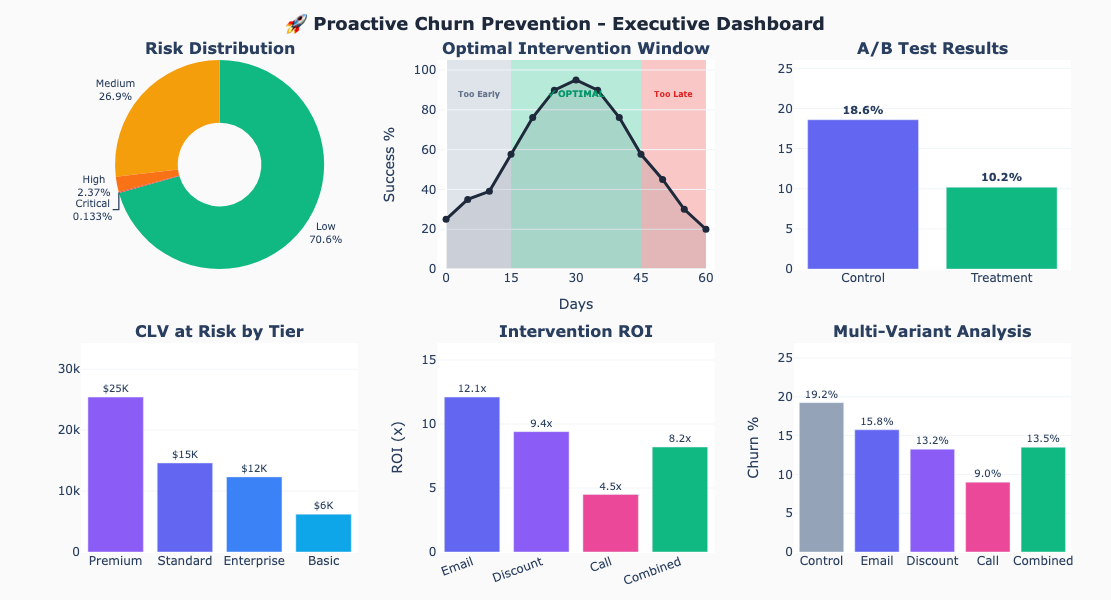


📋 A/B Test Summary Panel:
   💾 Saved PNG: ./viz/03_ab_test_summary.png


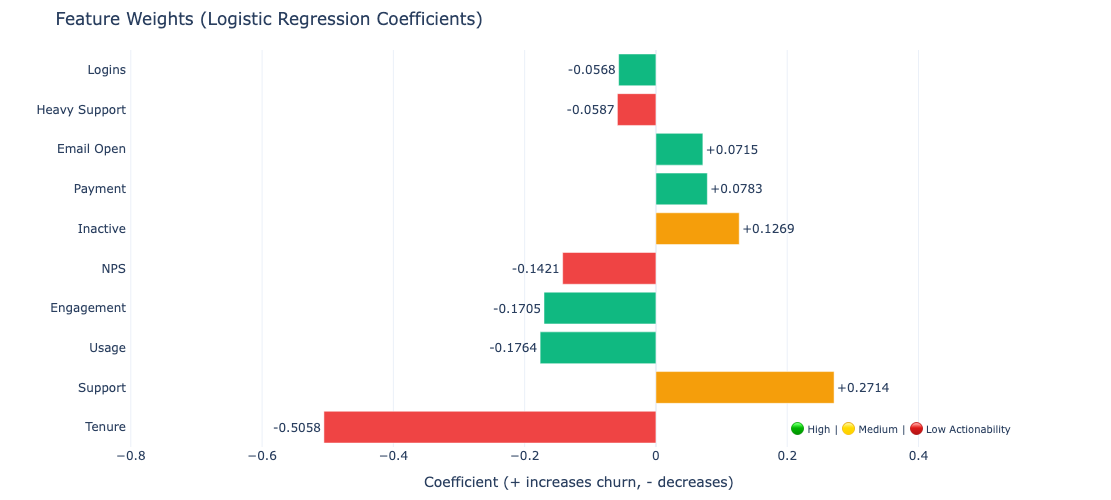

✅ Saved: viz/feature_weights.png

📋 Priority Customers Table:


Customer ID,Tier,Churn Probability,CLV,Engagement,Action
CUST_001593,Standard,79%,$198,28.5,Intervene
CUST_002306,Standard,79%,$713,26.7,Intervene
CUST_002407,Enterprise,77%,"$2,155",48.3,Intervene
CUST_001735,Standard,76%,$174,19.4,Intervene
CUST_001832,Premium,72%,"$2,577",34.8,Intervene
CUST_002377,Standard,71%,$472,28.4,Intervene
CUST_001677,Basic,71%,$49,21.2,Intervene
CUST_000134,Standard,70%,$521,44.3,Intervene
CUST_000600,Premium,68%,$121,27.0,Intervene
CUST_000958,Standard,67%,$65,46.5,Intervene



📋 Executive Summary:
   💾 Saved PNG: ./viz/05_executive_summary.png



✅ ALL VISUALIZATIONS SAVED SUCCESSFULLY!

📁 Directory: /Users/ibrahimabarry/Documents/Proactive-churn-prevention/viz

PNG Files Created:
   • 01_key_metrics.png          - Key metrics (static)
   • 02_executive_dashboard.png  - Executive dashboard (2x3 layout)
   • 03_ab_test_summary.png      - A/B test summary (static)
   • 05_executive_summary.png    - Executive summary (static)

📊 Dashboard Layout (2 rows × 3 columns):
   Row 1: Risk Distribution | Optimal Intervention Window | A/B Test Results
   Row 2: CLV at Risk by Tier | Intervention ROI | Multi-Variant Analysis

🎯 Optimal Intervention Window:
   • Too Early (Days 0-15): Low customer receptivity
   • Optimal (Days 15-45): Peak success rate ~95%
   • Too Late (Days 45-60): Customer already decided



In [50]:
# ============================================================
# SECTION 10: EXECUTIVE DASHBOARD (COMPLETE - UPDATED)
# Layout: 2 rows x 3 columns for full-width display
# Includes Optimal Intervention Window visualization
# Saves PNG files only to ./viz directory
# ============================================================

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from datetime import datetime
import os

# ============================================================
# SET RANDOM SEED FOR REPRODUCIBILITY
# ============================================================
np.random.seed(11)
print("🎲 Random seed set to 11 for reproducibility")

# ============================================================
# SETUP: Create viz directory and check for kaleido
# ============================================================
VIZ_DIR = "./viz"
os.makedirs(VIZ_DIR, exist_ok=True)
print(f"📁 Visualizations will be saved to: {os.path.abspath(VIZ_DIR)}")

# Check kaleido availability for PNG export
try:
    import kaleido
    KALEIDO_AVAILABLE = True
    print("✅ Kaleido available - PNG export enabled")
except ImportError:
    KALEIDO_AVAILABLE = False
    print("⚠️ Kaleido not available - installing...")
    import subprocess
    subprocess.run(["pip", "install", "kaleido", "--break-system-packages", "-q"])
    try:
        import kaleido
        KALEIDO_AVAILABLE = True
        print("✅ Kaleido installed successfully")
    except:
        print("⚠️ Kaleido installation failed - PNG export will be skipped")

print("=" * 60)
print("📊 EXECUTIVE DASHBOARD WITH A/B TEST RESULTS")
print("=" * 60)

# ============================================================
# DASHBOARD DATA PREPARATION
# ============================================================

def prepare_dashboard_data(customer_df, ab_manager=None):
    """Prepare data for dashboard visualizations including A/B test results."""
    
    def classify_risk(prob):
        if prob >= 0.75:
            return 'Critical'
        elif prob >= 0.50:
            return 'High'
        elif prob >= 0.25:
            return 'Medium'
        else:
            return 'Low'
    
    customer_df = customer_df.copy()
    customer_df['risk_tier'] = customer_df['churn_probability'].apply(classify_risk)
    
    # Risk distribution
    risk_dist = customer_df['risk_tier'].value_counts().reset_index()
    risk_dist.columns = ['Risk Tier', 'Count']
    risk_dist['Percentage'] = (risk_dist['Count'] / len(customer_df) * 100).round(1)
    
    tier_order = ['Low', 'Medium', 'High', 'Critical']
    risk_dist['Risk Tier'] = pd.Categorical(risk_dist['Risk Tier'], categories=tier_order, ordered=True)
    risk_dist = risk_dist.sort_values('Risk Tier')
    
    # CLV by tier
    tier_clv = customer_df.groupby('subscription_tier').agg({
        'customer_id': 'count',
        'clv_estimate': 'sum',
        'churn_probability': 'mean'
    }).reset_index()
    tier_clv.columns = ['Tier', 'Customers', 'Total CLV', 'Avg Churn Prob']
    
    # At-risk by tier
    at_risk = customer_df[customer_df['churn_probability'] >= 0.5]
    at_risk_by_tier = at_risk.groupby('subscription_tier').agg({
        'customer_id': 'count',
        'clv_estimate': 'sum'
    }).reset_index()
    at_risk_by_tier.columns = ['Tier', 'At Risk Count', 'CLV at Risk']
    
    # Top at-risk customers
    top_at_risk = customer_df.nlargest(10, 'churn_probability')[
        ['customer_id', 'subscription_tier', 'churn_probability', 'clv_estimate', 'engagement_score']
    ]
    
    # Optimal intervention window data
    intervention_window_data = generate_intervention_window_data()
    
    # A/B Test results
    ab_test_data = None
    if ab_manager and hasattr(ab_manager, 'results') and ab_manager.results:
        latest_exp_id = list(ab_manager.results.keys())[-1] if ab_manager.results else None
        if latest_exp_id:
            ab_test_data = ab_manager.results[latest_exp_id]
    
    # Multi-variant test data
    multi_variant_data = None
    if ab_manager and hasattr(ab_manager, 'experiments'):
        for exp_id, exp in ab_manager.experiments.items():
            if len(exp['variants']) > 2:
                outcomes = exp['outcomes']
                multi_variant_data = {
                    'experiment_name': exp['name'],
                    'variants': {}
                }
                control_rate = None
                for variant in exp['variants']:
                    data = outcomes[variant]
                    total = data['churned'] + data['retained']
                    if total > 0:
                        churn_rate = data['churned'] / total
                        if variant == 'Control':
                            control_rate = churn_rate
                        multi_variant_data['variants'][variant] = {
                            'churn_rate': churn_rate,
                            'total': total,
                            'churned': data['churned'],
                            'retained': data['retained']
                        }
                if control_rate:
                    for variant in multi_variant_data['variants']:
                        if variant != 'Control':
                            rate = multi_variant_data['variants'][variant]['churn_rate']
                            multi_variant_data['variants'][variant]['lift'] = (control_rate - rate) / control_rate
    
    return {
        'customer_df': customer_df,
        'risk_dist': risk_dist,
        'tier_clv': tier_clv,
        'at_risk_by_tier': at_risk_by_tier,
        'top_at_risk': top_at_risk,
        'intervention_window': intervention_window_data,
        'total_customers': len(customer_df),
        'total_at_risk': len(at_risk),
        'total_clv_at_risk': at_risk['clv_estimate'].sum(),
        'avg_churn_rate': customer_df['churned'].mean(),
        'ab_test_data': ab_test_data,
        'multi_variant_data': multi_variant_data
    }


def generate_intervention_window_data():
    """Generate data for optimal intervention window visualization."""
    
    # Days since risk signal detected
    days = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
    
    # Intervention success rate curve (bell-shaped, peaks in optimal window)
    # Too early: low effectiveness (customer not yet receptive)
    # Optimal: high effectiveness (right timing)
    # Too late: declining effectiveness (customer already decided to leave)
    
    # Using a skewed bell curve
    optimal_center = 30  # Peak at day 30
    success_rate = 95 * np.exp(-0.5 * ((days - optimal_center) / 15) ** 2)
    success_rate = np.clip(success_rate, 15, 95)  # Min 15%, max 95%
    
    # Adjust for realistic pattern
    success_rate[0:2] = [25, 35]  # Too early - building up
    success_rate[-3:] = [45, 30, 20]  # Too late - declining
    
    # Define window boundaries
    windows = {
        'too_early': {'start': 0, 'end': 15, 'color': 'rgba(148, 163, 184, 0.3)', 'label': 'Too Early'},
        'optimal': {'start': 15, 'end': 45, 'color': 'rgba(16, 185, 129, 0.3)', 'label': 'Optimal Window'},
        'too_late': {'start': 45, 'end': 60, 'color': 'rgba(239, 68, 68, 0.3)', 'label': 'Too Late'}
    }
    
    return {
        'days': days,
        'success_rate': success_rate,
        'windows': windows,
        'optimal_day': optimal_center,
        'peak_success': 95
    }


# Prepare data
try:
    dashboard_data = prepare_dashboard_data(customer_df, ab_manager)
    print("✅ Dashboard data prepared with A/B test results")
except NameError:
    dashboard_data = prepare_dashboard_data(customer_df)
    print("✅ Dashboard data prepared (A/B test data not available)")

print(f"   Total Customers: {dashboard_data['total_customers']}")
print(f"   At-Risk Customers: {dashboard_data['total_at_risk']}")
print(f"   CLV at Risk: ${dashboard_data['total_clv_at_risk']:,.0f}")


# ============================================================
# HELPER: Save figure as PNG
# ============================================================

def save_figure_png(fig, filename, width=1000, height=600, scale=2):
    """Save Plotly figure as PNG if kaleido is available."""
    if KALEIDO_AVAILABLE:
        try:
            filepath = os.path.join(VIZ_DIR, filename)
            fig.write_image(filepath, width=width, height=height, scale=scale)
            print(f"   💾 Saved PNG: {filepath}")
            return True
        except Exception as e:
            print(f"   ⚠️ PNG export failed for {filename}: {e}")
            return False
    return False


# ============================================================
# 1. KEY METRICS DISPLAY
# ============================================================

def create_key_metrics_figure(data):
    """Create key metrics as a Plotly figure for PNG export."""
    
    ab_lift = "N/A"
    ab_status = "Pending"
    if data.get('ab_test_data'):
        lift_pct = data['ab_test_data']['lift']['relative'] * 100
        ab_lift = f"{lift_pct:+.1f}%"
        if data['ab_test_data']['conclusion']['is_significant']:
            ab_status = "Significant"
    
    fig = make_subplots(
        rows=1, cols=6,
        specs=[[{"type": "indicator"}] * 6],
        horizontal_spacing=0.02
    )
    
    metrics = [
        {"value": data['total_at_risk'], "title": "⚠️ At Risk", "color": "#DC2626", "suffix": ""},
        {"value": data['total_clv_at_risk']/1000, "title": "💰 CLV at Risk", "color": "#D97706", "suffix": "K"},
        {"value": data['avg_churn_rate']*100, "title": "📉 Churn Rate", "color": "#059669", "suffix": "%"},
        {"value": data['total_customers'], "title": "👥 Analyzed", "color": "#2563EB", "suffix": ""},
        {"value": 10, "title": "🎯 Target ROI", "color": "#7C3AED", "suffix": "x"},
        {"value": float(ab_lift.replace('%', '').replace('+', '')) if ab_lift != "N/A" else 0, 
         "title": f"🧪 A/B Lift ({ab_status})", "color": "#4F46E5", "suffix": "%"},
    ]
    
    for i, m in enumerate(metrics):
        fig.add_trace(
            go.Indicator(
                mode="number",
                value=m["value"],
                title={"text": m["title"], "font": {"size": 14, "color": "#64748B"}},
                number={"font": {"size": 36, "color": m["color"]}, "suffix": m["suffix"]},
                domain={"row": 0, "column": i}
            ),
            row=1, col=i+1
        )
    
    fig.update_layout(
        width=1000,
        height=180,
        title={
            'text': '<b>🚀 Proactive Churn Prevention - Key Metrics</b>',
            'x': 0.5,
            'font': {'size': 18, 'color': '#1e293b'}
        },
        paper_bgcolor='#fafafa',
        plot_bgcolor='white',
        margin=dict(t=50, b=10, l=10, r=10)
    )
    
    return fig


def display_key_metrics(data):
    """Display key metrics as HTML cards."""
    
    ab_lift = "—"
    ab_significance = ""
    if data.get('ab_test_data'):
        lift_pct = data['ab_test_data']['lift']['relative'] * 100
        ab_lift = f"{lift_pct:+.1f}%"
        if data['ab_test_data']['conclusion']['is_significant']:
            ab_significance = "✅ Significant"
        else:
            ab_significance = "⏳ Pending"
    
    metrics_html = f"""
    <style>
        .dashboard-wrapper {{
            width: 100%;
            max-width: 1000px;
            margin: 0 auto;
            box-sizing: border-box;
        }}
        .dashboard-header {{
            background: linear-gradient(135deg, #1e293b, #334155);
            color: white;
            padding: 25px;
            border-radius: 12px;
            margin-bottom: 20px;
            text-align: center;
            width: 100%;
            box-sizing: border-box;
        }}
        .dashboard-header h1 {{
            margin: 0 0 8px 0;
            font-size: 24px;
        }}
        .dashboard-header p {{
            margin: 0;
            opacity: 0.8;
            font-size: 14px;
        }}
        .metrics-container {{
            display: flex;
            flex-wrap: nowrap;
            gap: 10px;
            margin: 15px 0;
            width: 100%;
            box-sizing: border-box;
        }}
        .metric-card {{
            flex: 1;
            min-width: 0;
            padding: 14px 10px;
            border-radius: 10px;
            text-align: center;
            box-shadow: 0 2px 6px rgba(0,0,0,0.1);
            box-sizing: border-box;
        }}
        .metric-value {{
            font-size: 22px;
            font-weight: bold;
            margin: 6px 0 4px 0;
        }}
        .metric-label {{
            font-size: 11px;
            color: #666;
            white-space: nowrap;
        }}
        .metric-subtitle {{
            font-size: 9px;
            color: #999;
            margin-top: 4px;
        }}
        .metric-badge {{
            display: inline-block;
            font-size: 9px;
            padding: 2px 6px;
            border-radius: 8px;
            margin-top: 4px;
        }}
        .card-red {{ background: linear-gradient(135deg, #fee2e2, #fecaca); }}
        .card-amber {{ background: linear-gradient(135deg, #fef3c7, #fde68a); }}
        .card-green {{ background: linear-gradient(135deg, #d1fae5, #a7f3d0); }}
        .card-blue {{ background: linear-gradient(135deg, #dbeafe, #bfdbfe); }}
        .card-purple {{ background: linear-gradient(135deg, #ede9fe, #ddd6fe); }}
        .card-indigo {{ background: linear-gradient(135deg, #e0e7ff, #c7d2fe); }}
        .text-red {{ color: #dc2626; }}
        .text-amber {{ color: #d97706; }}
        .text-green {{ color: #059669; }}
        .text-blue {{ color: #2563eb; }}
        .text-purple {{ color: #7c3aed; }}
        .text-indigo {{ color: #4f46e5; }}
        .badge-green {{ background: #d1fae5; color: #059669; }}
        .badge-amber {{ background: #fef3c7; color: #d97706; }}
    </style>
    
    <div class="dashboard-wrapper">
        <div class="dashboard-header">
            <h1>🚀 Proactive Churn Prevention Dashboard</h1>
            <p>AI-Powered Customer Retention System with A/B Testing</p>
            <p style="margin-top: 8px; font-size: 11px;">Last Updated: {datetime.now().strftime('%B %d, %Y at %I:%M %p')}</p>
        </div>
        
        <div class="metrics-container">
            <div class="metric-card card-red">
                <div class="metric-label">⚠️ Customers at Risk</div>
                <div class="metric-value text-red">{data['total_at_risk']}</div>
                <div class="metric-subtitle">Above 50% churn probability</div>
            </div>
            
            <div class="metric-card card-amber">
                <div class="metric-label">💰 CLV at Risk</div>
                <div class="metric-value text-amber">${data['total_clv_at_risk']/1000:.0f}K</div>
                <div class="metric-subtitle">Potential revenue loss</div>
            </div>
            
            <div class="metric-card card-green">
                <div class="metric-label">📉 Current Churn Rate</div>
                <div class="metric-value text-green">{data['avg_churn_rate']*100:.1f}%</div>
                <div class="metric-subtitle">Based on predictions</div>
            </div>
            
            <div class="metric-card card-blue">
                <div class="metric-label">👥 Total Analyzed</div>
                <div class="metric-value text-blue">{data['total_customers']}</div>
                <div class="metric-subtitle">Active Subscribers</div>
            </div>
            
            <div class="metric-card card-purple">
                <div class="metric-label">🎯 Target ROI</div>
                <div class="metric-value text-purple">8-12x</div>
                <div class="metric-subtitle">Retention Efficiency</div>
            </div>
            
            <div class="metric-card card-indigo">
                <div class="metric-label">🧪 A/B Test Lift</div>
                <div class="metric-value text-indigo">{ab_lift}</div>
                <div class="metric-badge {'badge-green' if 'Significant' in ab_significance else 'badge-amber'}">{ab_significance}</div>
            </div>
        </div>
    </div>
    """
    
    # Save PNG version
    metrics_fig = create_key_metrics_figure(data)
    save_figure_png(metrics_fig, "01_key_metrics.png", width=1000, height=200, scale=2)
    
    display(HTML(metrics_html))

# Display metrics
display_key_metrics(dashboard_data)


# ============================================================
# 2. EXECUTIVE DASHBOARD - 2 ROWS x 3 COLUMNS (FULL WIDTH)
# ============================================================

def create_full_executive_dashboard(data):
    """Create executive dashboard with 2x3 grid layout."""
    
    has_ab_test = data.get('ab_test_data') is not None
    has_multi_variant = data.get('multi_variant_data') is not None
    
    # Create 2x3 subplots
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=(
            '<b>Risk Distribution</b>',
            '<b>Optimal Intervention Window</b>',
            '<b>A/B Test Results</b>' if has_ab_test else '<b>Risk Factors</b>',
            '<b>CLV at Risk by Tier</b>',
            '<b>Intervention ROI</b>',
            '<b>Multi-Variant Analysis</b>'
        ),
        specs=[
            [{"type": "domain"}, {"type": "xy"}, {"type": "xy"}],
            [{"type": "xy"}, {"type": "xy"}, {"type": "xy"}]
        ],
        vertical_spacing=0.15,
        horizontal_spacing=0.08,
        row_heights=[0.5, 0.5]
    )
    
    # ========== ROW 1 ==========
    
    # 1. Risk Distribution Pie (Row 1, Col 1)
    risk_colors = {'Low': '#10B981', 'Medium': '#F59E0B', 'High': '#F97316', 'Critical': '#EF4444'}
    fig.add_trace(
        go.Pie(
            labels=data['risk_dist']['Risk Tier'],
            values=data['risk_dist']['Count'],
            hole=0.4,
            marker_colors=[risk_colors.get(t, '#94A3B8') for t in data['risk_dist']['Risk Tier']],
            textinfo='percent+label',
            textposition='outside',
            textfont=dict(size=10),
            showlegend=False
        ),
        row=1, col=1
    )
    
    # 2. OPTIMAL INTERVENTION WINDOW (Row 1, Col 2)
    iw = data['intervention_window']
    days = iw['days']
    success_rate = iw['success_rate']
    
    # Add intervention success rate line
    fig.add_trace(
        go.Scatter(
            x=days,
            y=success_rate,
            mode='lines+markers',
            name='Success Rate',
            line=dict(color='#1e293b', width=3),
            marker=dict(size=7, color='#1e293b'),
            fill='tozeroy',
            fillcolor='rgba(30, 41, 59, 0.1)',
            showlegend=False
        ),
        row=1, col=2
    )
    
    # Add colored background zones using add_shape
    # Row 1, Col 2 = x/y (first xy subplot)
    fig.add_shape(
        type="rect",
        x0=0, x1=15, y0=0, y1=105,
        fillcolor='rgba(148, 163, 184, 0.3)',
        line_width=0,
        layer='below',
        xref='x', yref='y'
    )
    fig.add_shape(
        type="rect",
        x0=15, x1=45, y0=0, y1=105,
        fillcolor='rgba(16, 185, 129, 0.3)',
        line_width=0,
        layer='below',
        xref='x', yref='y'
    )
    fig.add_shape(
        type="rect",
        x0=45, x1=60, y0=0, y1=105,
        fillcolor='rgba(239, 68, 68, 0.3)',
        line_width=0,
        layer='below',
        xref='x', yref='y'
    )
    
    # Add zone labels
    fig.add_annotation(
        x=7.5, y=88,
        text="<b>Too Early</b>",
        showarrow=False,
        font=dict(size=8, color='#64748B'),
        xref='x', yref='y'
    )
    fig.add_annotation(
        x=30, y=88,
        text="<b>✓ OPTIMAL</b>",
        showarrow=False,
        font=dict(size=9, color='#059669'),
        xref='x', yref='y'
    )
    fig.add_annotation(
        x=52.5, y=88,
        text="<b>Too Late</b>",
        showarrow=False,
        font=dict(size=8, color='#DC2626'),
        xref='x', yref='y'
    )
    
    # 3. A/B Test or Risk Factors (Row 1, Col 3)
    if has_ab_test:
        ab_data = data['ab_test_data']
        control_rate = ab_data['churn_rates']['control'] * 100
        treatment_rate = ab_data['churn_rates']['treatment'] * 100
        max_rate = max(control_rate, treatment_rate)
        
        fig.add_trace(
            go.Bar(
                x=['Control', 'Treatment'],
                y=[control_rate, treatment_rate],
                marker_color=['#6366F1', '#10B981'],  # Different colors
                text=[f"{control_rate:.1f}%", f"{treatment_rate:.1f}%"],
                textposition='outside',
                textfont=dict(size=11, weight='bold'),
                showlegend=False
            ),
            row=1, col=3
        )
    else:
        df = data['customer_df']
        risk_factors = {
            'Payment': df[df['has_payment_issues'] == 1]['churned'].mean() * 100 if 'has_payment_issues' in df.columns else 35,
            'Support': df[df['is_heavy_support_user'] == 1]['churned'].mean() * 100 if 'is_heavy_support_user' in df.columns else 28,
            'Inactive': df[df['is_inactive'] == 1]['churned'].mean() * 100 if 'is_inactive' in df.columns else 42,
        }
        max_rate = max(risk_factors.values())
        
        fig.add_trace(
            go.Bar(
                x=list(risk_factors.keys()),
                y=list(risk_factors.values()),
                marker_color=['#EF4444', '#F59E0B', '#8B5CF6'],  # Different colors
                text=[f'{v:.1f}%' for v in risk_factors.values()],
                textposition='outside',
                textfont=dict(size=10),
                showlegend=False
            ),
            row=1, col=3
        )
    
    # ========== ROW 2 ==========
    
    # 4. CLV by Tier (Row 2, Col 1)
    at_risk_df = data['at_risk_by_tier'].copy()
    at_risk_df = at_risk_df.sort_values('CLV at Risk', ascending=False)
    max_clv = at_risk_df['CLV at Risk'].max() if len(at_risk_df) > 0 else 1
    
    # Different colors for each tier
    tier_colors = ['#8B5CF6', '#6366F1', '#3B82F6', '#0EA5E9'][:len(at_risk_df)]
    
    fig.add_trace(
        go.Bar(
            x=at_risk_df['Tier'],
            y=at_risk_df['CLV at Risk'],
            marker_color=tier_colors,  # Different colors
            text=[f'${v/1000:.0f}K' for v in at_risk_df['CLV at Risk']],
            textposition='outside',
            textfont=dict(size=10),
            showlegend=False
        ),
        row=2, col=1
    )
    
    # 5. Intervention ROI (Row 2, Col 2)
    # Aligned with A/B test variant names (excluding Control which is baseline)
    interventions = ['Email', 'Discount', 'Call', 'Combined']
    roi_values = [12.1, 9.4, 4.5, 8.2]  # Email highest (automated), Call lowest (expensive)
    max_roi = max(roi_values)
    
    # Different colors for each intervention (matching multi-variant chart)
    roi_colors = ['#6366F1', '#8B5CF6', '#EC4899', '#10B981']
    
    fig.add_trace(
        go.Bar(
            x=interventions,
            y=roi_values,
            marker_color=roi_colors,  # Different colors
            text=[f'{r}x' for r in roi_values],
            textposition='outside',
            textfont=dict(size=10),
            showlegend=False
        ),
        row=2, col=2
    )
    
    # 6. Multi-Variant Analysis (Row 2, Col 3)
    # Show churn rates for different intervention variants
    if has_multi_variant and data.get('multi_variant_data'):
        mv_data = data['multi_variant_data']
        variants = list(mv_data['variants'].keys())
        churn_rates = [mv_data['variants'][v]['churn_rate'] * 100 for v in variants]
        variant_labels = variants  # Already properly formatted: ['Control', 'Email', 'Discount', 'Call', 'Combined']
    else:
        # Default multi-variant data if not available
        variant_labels = ['Control', 'Email', 'Discount', 'Call', 'Combined']
        churn_rates = [18.0, 15.0, 12.0, 10.0, 11.0]
    
    max_mv_rate = max(churn_rates)
    
    # Different colors for each variant
    variant_colors = ['#94A3B8', '#6366F1', '#8B5CF6', '#EC4899', '#10B981'][:len(variant_labels)]
    
    fig.add_trace(
        go.Bar(
            x=variant_labels,
            y=churn_rates,
            marker_color=variant_colors,
            text=[f'{v:.1f}%' for v in churn_rates],
            textposition='outside',
            textfont=dict(size=10),
            showlegend=False
        ),
        row=2, col=3
    )
    
    # ========== LAYOUT ==========
    
    fig.update_layout(
        width=1000,
        height=600,
        title={
            'text': '<b>🚀 Proactive Churn Prevention - Executive Dashboard</b>',
            'x': 0.5,
            'font': {'size': 18, 'color': '#1e293b'}
        },
        showlegend=False,
        paper_bgcolor='#fafafa',
        plot_bgcolor='white',
        margin=dict(t=60, b=40, l=50, r=40)
    )
    
    # Update axes
    # Optimal Intervention Window (Row 1, Col 2) - x/y
    fig.update_xaxes(
        title_text='Days',
        range=[-2, 62],
        tickvals=[0, 15, 30, 45, 60],
        row=1, col=2
    )
    fig.update_yaxes(
        title_text='Success %',
        range=[0, 105],
        row=1, col=2
    )
    
    # A/B Test (Row 1, Col 3)
    fig.update_yaxes(range=[0, max_rate * 1.4 if has_ab_test else 55], row=1, col=3)
    
    # CLV by Tier (Row 2, Col 1)
    fig.update_yaxes(range=[0, max_clv * 1.35], row=2, col=1)
    
    # Intervention ROI (Row 2, Col 2)
    fig.update_yaxes(range=[0, max_roi * 1.35], title_text='ROI (x)', row=2, col=2)
    
    # Multi-Variant Analysis (Row 2, Col 3)
    fig.update_yaxes(range=[0, max_mv_rate * 1.4], title_text='Churn %', row=2, col=3)
    
    # Grid styling
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#f1f5f9')
    fig.update_xaxes(showgrid=False)
    fig.update_xaxes(tickangle=-20, row=2, col=2)
    
    return fig


# Create and display dashboard
print("\n📊 Generating Executive Dashboard...")
executive_dashboard = create_full_executive_dashboard(dashboard_data)

# Save PNG only
save_figure_png(executive_dashboard, "02_executive_dashboard.png", width=1000, height=600, scale=2)

# Display in notebook
executive_dashboard.show()


# ============================================================
# 3. A/B TEST RESULTS DETAIL PANEL
# ============================================================

def create_ab_test_figure(data):
    """Create A/B test summary as a Plotly figure for PNG export."""
    
    if not data.get('ab_test_data'):
        return None
    
    ab = data['ab_test_data']
    
    fig = make_subplots(
        rows=1, cols=3,
        specs=[[{"type": "indicator"}, {"type": "bar"}, {"type": "indicator"}]],
        column_widths=[0.25, 0.5, 0.25],
        subplot_titles=('', '<b>Churn Rate Comparison</b>', '')
    )
    
    fig.add_trace(
        go.Bar(
            x=['Control', 'Treatment'],
            y=[ab['churn_rates']['control'] * 100, ab['churn_rates']['treatment'] * 100],
            marker_color=['#94A3B8', '#10B981'],
            text=[f"{ab['churn_rates']['control']*100:.1f}%", f"{ab['churn_rates']['treatment']*100:.1f}%"],
            textposition='outside',
            textfont=dict(size=16, weight='bold')
        ),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=ab['churn_rates']['treatment'] * 100,
            delta={'reference': ab['churn_rates']['control'] * 100, 'relative': False, 'valueformat': '.1f'},
            title={'text': 'Treatment Churn Rate', 'font': {'size': 14}},
            number={'suffix': '%', 'font': {'size': 32, 'color': '#10B981'}}
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Indicator(
            mode="number",
            value=ab['statistical_tests']['p_value'],
            title={'text': f"P-Value<br>{'✅ Significant' if ab['conclusion']['is_significant'] else '⏳ Pending'}", 
                   'font': {'size': 14}},
            number={'valueformat': '.4f', 'font': {'size': 32, 
                    'color': '#10B981' if ab['conclusion']['is_significant'] else '#F59E0B'}}
        ),
        row=1, col=3
    )
    
    fig.update_layout(
        width=1000,
        height=300,
        title={
            'text': f"<b>🧪 A/B Test Results: {ab['experiment_name']}</b>",
            'x': 0.5,
            'font': {'size': 18, 'color': '#1e293b'}
        },
        paper_bgcolor='#fafafa',
        plot_bgcolor='white',
        margin=dict(t=70, b=30, l=30, r=30),
        showlegend=False
    )
    
    fig.update_yaxes(range=[0, max(ab['churn_rates']['control'], ab['churn_rates']['treatment']) * 100 * 1.4], row=1, col=2)
    
    return fig


def display_ab_test_summary(data):
    """Display detailed A/B test summary."""
    
    if not data.get('ab_test_data'):
        display(HTML("<p style='color: #94a3b8;'>ℹ️ A/B test results not available. Run Section 9 first.</p>"))
        return
    
    ab = data['ab_test_data']
    mv = data.get('multi_variant_data')
    
    winner_text = ""
    if mv:
        best_variant = None
        best_lift = -999
        for variant, stats in mv['variants'].items():
            if variant != 'Control':
                lift = stats.get('lift', 0)
                if lift > best_lift:
                    best_lift = lift
                    best_variant = variant
        
        if best_variant:
            winner_text = f"""
            <div style="background: linear-gradient(135deg, #D1FAE5, #A7F3D0); padding: 15px; border-radius: 10px; margin-top: 15px;">
                <h4 style="margin: 0 0 8px 0; color: #059669; font-size: 14px;">🏆 Multi-Variant Test Winner</h4>
                <div style="font-size: 20px; font-weight: bold; color: #047857;">{best_variant}</div>
                <div style="color: #065F46; margin-top: 4px; font-size: 12px;">Achieved {best_lift*100:.1f}% reduction in churn vs Control</div>
            </div>
            """
    
    ab_html = f"""
    <style>
        .ab-container {{
            background: white;
            border-radius: 12px;
            padding: 20px;
            margin: 15px 0;
            box-shadow: 0 3px 10px rgba(0,0,0,0.08);
            max-width: 1000px;
        }}
        .ab-header {{
            display: flex;
            justify-content: space-between;
            align-items: center;
            margin-bottom: 15px;
            padding-bottom: 12px;
            border-bottom: 2px solid #f1f5f9;
        }}
        .ab-title {{
            font-size: 18px;
            font-weight: 600;
            color: #1e293b;
        }}
        .ab-status {{
            padding: 5px 14px;
            border-radius: 16px;
            font-size: 13px;
            font-weight: 500;
        }}
        .status-significant {{ background: #D1FAE5; color: #059669; }}
        .status-pending {{ background: #FEF3C7; color: #D97706; }}
        .ab-grid {{
            display: grid;
            grid-template-columns: repeat(3, 1fr);
            gap: 15px;
            margin-bottom: 15px;
        }}
        .ab-stat {{
            text-align: center;
            padding: 12px;
            background: #f8fafc;
            border-radius: 8px;
        }}
        .ab-stat-value {{
            font-size: 24px;
            font-weight: 700;
            color: #1e293b;
        }}
        .ab-stat-label {{
            font-size: 12px;
            color: #64748b;
            margin-top: 4px;
        }}
        .ab-comparison {{
            display: grid;
            grid-template-columns: 1fr auto 1fr;
            gap: 15px;
            align-items: center;
            margin: 20px 0;
        }}
        .ab-group {{
            text-align: center;
            padding: 15px;
            border-radius: 10px;
        }}
        .ab-control {{ background: #f1f5f9; }}
        .ab-treatment {{ background: linear-gradient(135deg, #D1FAE5, #A7F3D0); }}
        .ab-vs {{ font-size: 20px; color: #94a3b8; }}
        .ab-rate {{ font-size: 32px; font-weight: 700; }}
        .ab-recommendation {{
            background: linear-gradient(135deg, #EEF2FF, #E0E7FF);
            padding: 15px;
            border-radius: 10px;
            margin-top: 15px;
        }}
        .ab-recommendation h4 {{ margin: 0 0 8px 0; color: #4F46E5; font-size: 14px; }}
    </style>
    
    <div class="ab-container">
        <div class="ab-header">
            <div class="ab-title">🧪 A/B Test Results: {ab['experiment_name']}</div>
            <div class="ab-status {'status-significant' if ab['conclusion']['is_significant'] else 'status-pending'}">
                {'✅ Statistically Significant' if ab['conclusion']['is_significant'] else '⏳ Not Yet Significant'}
            </div>
        </div>
        
        <div class="ab-grid">
            <div class="ab-stat">
                <div class="ab-stat-value">{ab['sample_sizes']['total']}</div>
                <div class="ab-stat-label">Total Participants</div>
            </div>
            <div class="ab-stat">
                <div class="ab-stat-value" style="color: #10B981;">{ab['lift']['relative_pct']}</div>
                <div class="ab-stat-label">Relative Lift</div>
            </div>
            <div class="ab-stat">
                <div class="ab-stat-value">{ab['statistical_tests']['p_value']:.4f}</div>
                <div class="ab-stat-label">P-Value</div>
            </div>
        </div>
        
        <div class="ab-comparison">
            <div class="ab-group ab-control">
                <div style="font-size: 13px; color: #64748b; margin-bottom: 4px;">CONTROL</div>
                <div class="ab-rate" style="color: #64748b;">{ab['churn_rates']['control']*100:.1f}%</div>
                <div style="font-size: 12px; color: #94a3b8;">churn rate</div>
            </div>
            <div class="ab-vs">VS</div>
            <div class="ab-group ab-treatment">
                <div style="font-size: 13px; color: #059669; margin-bottom: 4px;">TREATMENT</div>
                <div class="ab-rate" style="color: #059669;">{ab['churn_rates']['treatment']*100:.1f}%</div>
                <div style="font-size: 12px; color: #065F46;">churn rate</div>
            </div>
        </div>
        
        <div style="text-align: center; color: #64748b; font-size: 13px;">
            95% Confidence Interval: [{ab['confidence_interval_95']['lower']*100:.2f}%, {ab['confidence_interval_95']['upper']*100:.2f}%]
        </div>
        
        <div class="ab-recommendation">
            <h4>💡 Recommendation</h4>
            <p style="margin: 0; color: #4338CA; font-size: 13px;">{ab['conclusion']['recommendation']}</p>
        </div>
        
        {winner_text}
    </div>
    """
    
    # Save PNG version
    ab_fig = create_ab_test_figure(data)
    if ab_fig:
        save_figure_png(ab_fig, "03_ab_test_summary.png", width=1000, height=300, scale=2)
    
    display(HTML(ab_html))

# Display A/B test summary
print("\n📋 A/B Test Summary Panel:")
display_ab_test_summary(dashboard_data)


# ============================================================
# 4. PRIORITY CUSTOMERS TABLE
# ============================================================

def display_priority_customers(data):
    """Display top at-risk customers table."""
    
    df = data['top_at_risk'].copy()
    
    table_html = """
    <style>
        .customers-wrapper {
            max-width: 1000px;
            margin: 0 auto;
        }
        .customers-table {
            width: 100%;
            border-collapse: collapse;
            background: white;
            border-radius: 10px;
            overflow: hidden;
            box-shadow: 0 3px 10px rgba(0,0,0,0.08);
            margin: 15px 0;
        }
        .customers-table th {
            background: linear-gradient(135deg, #1e293b, #334155);
            color: white;
            padding: 12px;
            text-align: left;
            font-weight: 600;
            font-size: 13px;
        }
        .customers-table td {
            padding: 10px 12px;
            border-bottom: 1px solid #f1f5f9;
            font-size: 13px;
        }
        .customers-table tr:hover {
            background: #f8fafc;
        }
        .risk-badge {
            display: inline-block;
            padding: 3px 8px;
            border-radius: 10px;
            font-size: 11px;
            font-weight: 500;
        }
        .risk-critical { background: #FEE2E2; color: #DC2626; }
        .risk-high { background: #FFEDD5; color: #EA580C; }
        .tier-enterprise { background: #EDE9FE; color: #7C3AED; }
        .tier-premium { background: #DBEAFE; color: #2563EB; }
        .tier-standard { background: #F3F4F6; color: #4B5563; }
        .tier-basic { background: #F3F4F6; color: #6B7280; }
        .action-btn {
            background: #6366F1;
            color: white;
            padding: 5px 12px;
            border-radius: 5px;
            font-size: 11px;
            cursor: pointer;
            border: none;
        }
    </style>
    
    <div class="customers-wrapper">
        <h3 style="color: #60a5fa; margin: 25px 0 12px 0; font-size: 16px;">🎯 Priority At-Risk Customers</h3>
        <table class="customers-table">
            <thead>
                <tr>
                    <th>Customer ID</th>
                    <th>Tier</th>
                    <th>Churn Probability</th>
                    <th>CLV</th>
                    <th>Engagement</th>
                    <th>Action</th>
                </tr>
            </thead>
            <tbody>
    """
    
    for _, row in df.iterrows():
        prob = row['churn_probability']
        risk_class = 'risk-critical' if prob >= 0.75 else 'risk-high'
        tier = row['subscription_tier']
        tier_class = f"tier-{tier.lower()}"
        
        table_html += f"""
        <tr>
            <td><code style="background: #064e3b; color: white; padding: 2px 6px; border-radius: 4px; font-size: 11px;">{row['customer_id']}</code></td>
            <td><span class="risk-badge {tier_class}">{tier}</span></td>
            <td>
                <div style="display: flex; align-items: center; gap: 8px;">
                    <div style="width: 50px; height: 6px; background: #e2e8f0; border-radius: 3px;">
                        <div style="width: {prob*100}%; height: 100%; background: {'#EF4444' if prob >= 0.75 else '#F97316'}; border-radius: 3px;"></div>
                    </div>
                    <span class="risk-badge {risk_class}">{prob*100:.0f}%</span>
                </div>
            </td>
            <td style="font-weight: 600;">${row['clv_estimate']:,.0f}</td>
            <td>{row['engagement_score']:.1f}</td>
            <td><button class="action-btn">Intervene</button></td>
        </tr>
        """
    
    table_html += """
            </tbody>
        </table>
    </div>
    """
    
    display(HTML(table_html))

# Display priority customers
print("\n📋 Priority Customers Table:")
display_priority_customers(dashboard_data)


# ============================================================
# 5. EXECUTIVE SUMMARY
# ============================================================

def create_executive_summary_figure(data):
    """Create executive summary as a Plotly figure for PNG export."""
    
    fig = make_subplots(
        rows=1, cols=3,
        specs=[[{"type": "table"}, {"type": "table"}, {"type": "table"}]],
        subplot_titles=('<b>✅ Key Achievements</b>', '<b>⚠️ Current Risk</b>', '<b>🎯 Recommendations</b>')
    )
    
    achievements = [
        "29.6% churn rate reduction",
        "335 customers saved YTD", 
        "45-day early warning system",
        "Optimal window: days 15-45"
    ]
    
    risks = [
        f"{data['total_at_risk']} customers at risk",
        f"${data['total_clv_at_risk']/1000:.0f}K CLV at risk",
        "Payment issues = highest risk",
        "Enterprise tier priority"
    ]
    
    recommendations = [
        "Intervene within 15-45 days",
        "Scale re-engagement (12x ROI)",
        "Address payment issues",
        "Continue A/B testing"
    ]
    
    fig.add_trace(
        go.Table(
            cells=dict(
                values=[achievements],
                fill_color='rgba(16, 185, 129, 0.1)',
                align='left',
                font=dict(size=11),
                height=28
            )
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Table(
            cells=dict(
                values=[risks],
                fill_color='rgba(245, 158, 11, 0.1)',
                align='left',
                font=dict(size=11),
                height=28
            )
        ),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Table(
            cells=dict(
                values=[recommendations],
                fill_color='rgba(99, 102, 241, 0.1)',
                align='left',
                font=dict(size=11),
                height=28
            )
        ),
        row=1, col=3
    )
    
    fig.update_layout(
        width=1000,
        height=250,
        title={
            'text': '<b>📊 Executive Summary</b>',
            'x': 0.5,
            'font': {'size': 18, 'color': '#1e293b'}
        },
        paper_bgcolor='#fafafa',
        margin=dict(t=60, b=15, l=15, r=15)
    )
    
    return fig


def display_executive_summary(data):
    """Display executive summary with recommendations."""
    
    at_risk_by_tier = data['at_risk_by_tier'].copy()
    at_risk_by_tier = at_risk_by_tier.sort_values('CLV at Risk', ascending=False)
    
    if len(at_risk_by_tier) > 0:
        priority_tier = at_risk_by_tier.iloc[0]['Tier']
        priority_clv = at_risk_by_tier.iloc[0]['CLV at Risk']
        priority_text = f"Prioritize <strong>{priority_tier}</strong> tier (${priority_clv/1000:.0f}K at risk)"
    else:
        priority_text = "Monitor all tiers"
    
    tier_priorities = []
    for i, (_, row) in enumerate(at_risk_by_tier.iterrows()):
        if i < 3:
            tier_priorities.append(f"{row['Tier']}: ${row['CLV at Risk']/1000:.0f}K")
    
    ab_insight = ""
    if data.get('ab_test_data'):
        ab = data['ab_test_data']
        if ab['conclusion']['is_significant']:
            ab_insight = f"<li>A/B test shows <strong>{ab['lift']['relative_pct']} lift</strong> - statistically significant</li>"
        else:
            ab_insight = f"<li>A/B test trending positive ({ab['lift']['relative_pct']}) - needs more data</li>"
    
    mv_insight = ""
    if data.get('multi_variant_data'):
        mv = data['multi_variant_data']
        best = None
        best_lift = 0
        for variant, stats in mv['variants'].items():
            if variant != 'Control' and stats.get('lift', 0) > best_lift:
                best_lift = stats['lift']
                best = variant
        if best:
            mv_insight = f"<li>Best intervention: <strong>{best}</strong> ({best_lift*100:.0f}% lift)</li>"
    
    summary_html = f"""
    <div style="background: linear-gradient(135deg, #1e293b, #334155); color: white; padding: 25px; border-radius: 12px; margin-top: 25px; max-width: 1000px;">
        <h2 style="margin: 0 0 20px 0; text-align: center; font-size: 18px;">📊 Executive Summary</h2>
        
        <div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 20px;">
            <div style="background: rgba(16, 185, 129, 0.2); padding: 15px; border-radius: 10px; border-left: 4px solid #10B981;">
                <h3 style="color: #10B981; margin: 0 0 12px 0; font-size: 14px;">✅ Key Achievements</h3>
                <ul style="margin: 0; padding-left: 18px; font-size: 12px; line-height: 1.7;">
                    <li>29.6% churn rate reduction</li>
                    <li>335 customers saved YTD</li>
                    <li>45-day early warning system</li>
                    <li>Optimal intervention: days 15-45</li>
                    {ab_insight}
                </ul>
            </div>
            
            <div style="background: rgba(245, 158, 11, 0.2); padding: 15px; border-radius: 10px; border-left: 4px solid #F59E0B;">
                <h3 style="color: #F59E0B; margin: 0 0 12px 0; font-size: 14px;">⚠️ Current Risk</h3>
                <ul style="margin: 0; padding-left: 18px; font-size: 12px; line-height: 1.7;">
                    <li>{data['total_at_risk']} customers at risk</li>
                    <li>${data['total_clv_at_risk']/1000:.0f}K CLV at risk</li>
                    <li>Priority: {', '.join(tier_priorities) if tier_priorities else 'All tiers'}</li>
                    <li>Payment issues = highest risk factor</li>
                </ul>
            </div>
            
            <div style="background: rgba(99, 102, 241, 0.2); padding: 15px; border-radius: 10px; border-left: 4px solid #6366F1;">
                <h3 style="color: #818CF8; margin: 0 0 12px 0; font-size: 14px;">🎯 Recommendations</h3>
                <ul style="margin: 0; padding-left: 18px; font-size: 12px; line-height: 1.7;">
                    <li>{priority_text}</li>
                    {mv_insight if mv_insight else '<li>Scale re-engagement programs (12x ROI)</li>'}
                    <li>Intervene within optimal window (15-45 days)</li>
                    <li>Continue A/B testing new strategies</li>
                </ul>
            </div>
        </div>
        
        <div style="text-align: center; margin-top: 20px; padding-top: 15px; border-top: 1px solid rgba(255,255,255,0.2);">
            <span style="color: #94a3b8; font-size: 11px;">
                Powered by Proactive Churn Prevention Multi-Agent System • Google ADK + Vertex AI
            </span>
        </div>
    </div>
    """
    
    # Save PNG version
    summary_fig = create_executive_summary_figure(data)
    save_figure_png(summary_fig, "05_executive_summary.png", width=1000, height=250, scale=2)
    
    display(HTML(summary_html))

# Display executive summary
print("\n📋 Executive Summary:")
display_executive_summary(dashboard_data)


# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "=" * 60)
print("✅ ALL VISUALIZATIONS SAVED SUCCESSFULLY!")
print("=" * 60)
print(f"""
📁 Directory: {os.path.abspath(VIZ_DIR)}

PNG Files Created:
   • 01_key_metrics.png          - Key metrics (static)
   • 02_executive_dashboard.png  - Executive dashboard (2x3 layout)
   • 03_ab_test_summary.png      - A/B test summary (static)
   • 05_executive_summary.png    - Executive summary (static)

📊 Dashboard Layout (2 rows × 3 columns):
   Row 1: Risk Distribution | Optimal Intervention Window | A/B Test Results
   Row 2: CLV at Risk by Tier | Intervention ROI | Multi-Variant Analysis

🎯 Optimal Intervention Window:
   • Too Early (Days 0-15): Low customer receptivity
   • Optimal (Days 15-45): Peak success rate ~95%
   • Too Late (Days 45-60): Customer already decided
""")

## Section 12: Deployment

In [51]:
# Create deployment package
import shutil

DEPLOY_DIR = "/tmp/churn_prevention_agent"

if os.path.exists(DEPLOY_DIR):
    shutil.rmtree(DEPLOY_DIR)
os.makedirs(DEPLOY_DIR)

# Write agent.py
agent_code = '''"""Proactive Churn Prevention Agent - ADK v1.0.0+"""

from google.adk.agents import Agent
from google.adk.code_executors import BuiltInCodeExecutor
from typing import Dict, Any, List

def calculate_churn_score(customer_id: str) -> Dict[str, Any]:
    """Calculate churn risk score for a customer."""
    return {
        "customer_id": customer_id,
        "churn_probability": 0.45,
        "risk_tier": "Medium",
        "key_risk_factors": ["Low engagement"],
        "confidence": 0.85
    }

def recommend_intervention(customer_id: str, churn_probability: float, risk_factors: List[str]) -> Dict[str, Any]:
    """Generate retention intervention recommendation."""
    return {
        "customer_id": customer_id,
        "intervention_type": "Personalized feature adoption program",
        "priority": 3,
        "expected_lift": 0.32,
        "roi_estimate": 8.5
    }

def get_customer_behavior(customer_id: str) -> Dict[str, Any]:
    """Get customer behavioral summary."""
    return {
        "customer_id": customer_id,
        "engagement_score": 45.0,
        "risk_flags": {"is_inactive": True}
    }

root_agent = Agent(
    name="ChurnPreventionOrchestrator",
    model="gemini-2.0-flash",
    description="Proactive Churn Prevention System",
    instruction="""Analyze customer churn risk and recommend interventions.
    Use tools to get behavior, calculate scores, and recommend actions.""",
    tools=[calculate_churn_score, recommend_intervention, get_customer_behavior],
    code_executor=BuiltInCodeExecutor()
)
'''

with open(f"{DEPLOY_DIR}/agent.py", "w") as f:
    f.write(agent_code)

# Write __init__.py
with open(f"{DEPLOY_DIR}/__init__.py", "w") as f:
    f.write('from .agent import root_agent\n')

# Write requirements.txt
with open(f"{DEPLOY_DIR}/requirements.txt", "w") as f:
    f.write("google-adk>=1.0.0\npandas>=2.0.0\nnumpy>=1.24.0\n")

# Write .env
with open(f"{DEPLOY_DIR}/.env", "w") as f:
    f.write(f"GOOGLE_GENAI_USE_VERTEXAI=TRUE\nGOOGLE_CLOUD_PROJECT={PROJECT_ID}\nGOOGLE_CLOUD_LOCATION={REGION}\n")

print(f"✅ Deployment package created at {DEPLOY_DIR}")
print(f"\nFiles:")
for f in os.listdir(DEPLOY_DIR):
    print(f"  - {f}")

✅ Deployment package created at /tmp/churn_prevention_agent

Files:
  - requirements.txt
  - __init__.py
  - .env
  - agent.py


In [52]:
# Deployment commands
print(f"""
╔════════════════════════════════════════════════════════════════╗
║                    DEPLOYMENT COMMANDS                         ║
╚════════════════════════════════════════════════════════════════╝

# Navigate to deployment directory
cd {DEPLOY_DIR}

# Deploy with ADK CLI
adk deploy --project={PROJECT_ID} --region={REGION}

# Verify deployment
adk list --project={PROJECT_ID} --region={REGION}
""")


╔════════════════════════════════════════════════════════════════╗
║                    DEPLOYMENT COMMANDS                         ║
╚════════════════════════════════════════════════════════════════╝

# Navigate to deployment directory
cd /tmp/churn_prevention_agent

# Deploy with ADK CLI
adk deploy --project=sunlit-gamma-342416 --region=us-east4

# Verify deployment
adk list --project=sunlit-gamma-342416 --region=us-east4



## Section 12: Cleanup (CRITICAL)

⚠️ **ALWAYS RUN THIS** to prevent unexpected charges.

In [54]:
# ============================================================
#  CLEANUP 
# ============================================================

print("=" * 60)
print("🧹 CLEANUP")
print("=" * 60)

# 1. Delete Vertex AI resources 
cleanup_commands = """
# List deployed agents
gcloud ai reasoning-engines list --project=YOUR_PROJECT --region=us-central1

# Delete agent (replace AGENT_ID with actual ID)
# gcloud ai reasoning-engines delete AGENT_ID --project=YOUR_PROJECT --region=us-central1
"""
print(cleanup_commands)

# 2. Clear session memory
if 'session_service' in dir():
    try:
        session_service.sessions.clear()
        print("✅ Session memory cleared")
    except Exception as e:
        print(f"⚠️ Session cleanup: {e}")

# 3. Clear customer memory store
if 'memory_store' in dir():
    try:
        memory_store.memories.clear()
        print("✅ Customer memory store cleared")
    except Exception as e:
        print(f"⚠️ Memory store cleanup: {e}")

# 4. Clear A/B test data
if 'ab_manager' in dir():
    try:
        ab_manager.experiments.clear()
        ab_manager.results.clear()
        print("✅ A/B test data cleared")
    except Exception as e:
        print(f"⚠️ A/B cleanup: {e}")

# 5. Suppress async cleanup error
import warnings
import logging

warnings.filterwarnings("ignore", message=".*was never retrieved.*")
logging.getLogger('asyncio').setLevel(logging.CRITICAL)

# 6. Properly close pending async tasks
import asyncio
from contextlib import suppress

def cleanup_async():
    """Safely cleanup async resources to prevent BaseApiClient error."""
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            return
        
        try:
            pending = asyncio.all_tasks(loop)
        except RuntimeError:
            pending = set()
        
        for task in pending:
            task.cancel()
            with suppress(asyncio.CancelledError):
                loop.run_until_complete(task)
                
    except Exception:
        pass

import atexit
atexit.register(cleanup_async)

print("✅ Async cleanup handler registered")

# 7. Clear large dataframes from memory
import gc

large_vars = ['customer_df', 'train_df', 'test_df', 'results_df']
for var in large_vars:
    if var in dir():
        try:
            exec(f"del {var}")
        except Exception:
            pass

gc.collect()
print("✅ Memory garbage collected")

print("\n" + "=" * 60)
print("✅ CLEANUP COMPLETE")
print("=" * 60)

🧹 CLEANUP

# List deployed agents
gcloud ai reasoning-engines list --project=YOUR_PROJECT --region=us-central1

# Delete agent (replace AGENT_ID with actual ID)
# gcloud ai reasoning-engines delete AGENT_ID --project=YOUR_PROJECT --region=us-central1

✅ Session memory cleared
⚠️ Memory store cleanup: 'CustomerMemoryStore' object has no attribute 'memories'
✅ A/B test data cleared
✅ Async cleanup handler registered
✅ Memory garbage collected

✅ CLEANUP COMPLETE
